### Authors
### Group 3 Members

1. Michael Mumina (Scrum Master)
2. Sharon Nyakeya
3. Bryan Njogu
4. Ashley Kibwogo
5. Tanveer Chege
6. Claris Wangari
7. Priscillah Giriama

# Sudan Food Insecurity and Displacement Model

This analysis delivers a decision-ready prototype for humanitarian early warning, providing forward-looking identification of food insecurity deterioration, displacement pressure, and key risk drivers at relevant administrative levels. 

The model integrates multi-sector signals into a coherent risk framework that supports prioritization and situational awareness. 

While advanced components such as probabilistic uncertainty bounds, formal hotspot clustering, and response-rule optimization are not yet operationalized, the current system establishes a robust analytical backbone that can be readily extended into a fully operational decision-support tool.

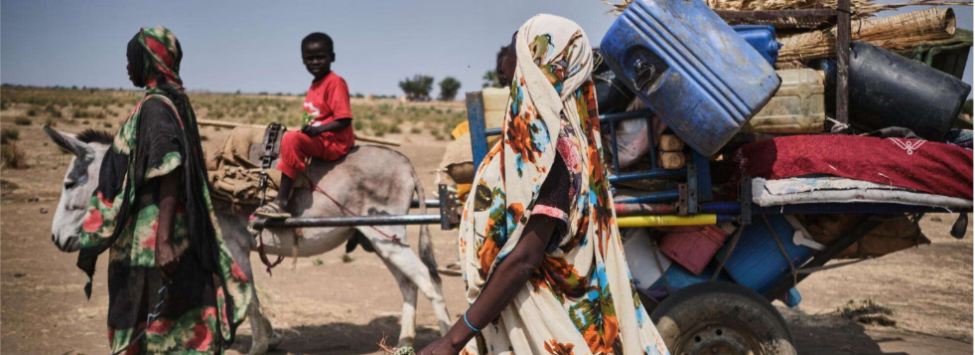

Point of Reference:
IPC Sudan Acute Food Insecurity Snapshot (Oct 2024 – May 2025): https://www.ipcinfo.org/fileadmin/user_upload/ipcinfo/docs/IPC_Sudan_Acute_Food_Insecurity_Oct2024_May2025_Snapshot.pdf

## 1) Business Understanding

### 1.1 Problem Scope:

The prototype is immediately usable for strategic planning and anticipatory action, enabling decision-makers to:
- Identify where conditions are likely to deteriorate in the coming month
- Compare displacement pressure across states and localities
- Understand the primary drivers contributing to elevated risk

Most existing systems are **reactive snapshots**. 
Our project aims to provide key inputs to the above listed key points.


## Target Stakeholders

Our main stake holders are :
1. Humanitarian Aid Organizations such as WHO, UN , UNEP etc
2. Sudan Government 

## 2) Project Objectives
## a. IPC Food Insecurity Forecasting (State Level) 
Forecast one month ahead:
- **Regression:** next-month IPC3+ percentage  
- **Classification:** probability that IPC3+ worsens next month ( 2 percentage point increase)

Outputs:
- monthly risk ranking by state  
- top drivers for each state-month prediction  
- uncertainty/confidence flags

## b. Displacement Pressure Monitoring and Hotspot Intelligence

Produce monthly operational outputs:
- **State pressure rankings**:
  - total IDPs by state
- **Hotspot and concentration intelligence**:
  - top localities contributing to state IDP burden
  - concentration measures (e.g., top 3 localities share)

Why this matters:
- High displacement pressure increases vulnerability via service strain, market stress, and household fragility.
- Hotspot intelligence supports locality-level targeting (Admin2) for assessments and interventions.


## 3. Data Understanding & Preparation



Our model has been built on various data sets namely:

1. IPC datasets — Food insecurity truth signal
2. Displacement datasets — Needs and pressure signal
3. WFP price datasets — Economic stress signal
4. Rainfall dataset — Climate stress signal
5. Conflict datasets — Shock and disruption signal
6. Population and vulnerability — Exposure and normalization

### Import the required Libraries which will be used in the project. 

In [1]:
#import libraries
import pandas as pd                                          # For working with datasets (tables, CSV, Excel, dataframes)
import numpy as np                                           # For numerical operations, arrays, math functions
import matplotlib.pyplot as plt                              # For plotting graphs and data visualizations
import seaborn as sns                                        # For advanced statistical visualizations built on top of matplotlib
from sklearn.model_selection import train_test_split         # Split data into training and testing sets
from sklearn.linear_model import LogisticRegression          # Logistic Regression classifier
from sklearn.ensemble import RandomForestClassifier          # Ensemble model using multiple decision trees
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score    # Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report                    # Confusion matrix & summary report
import glob                                                  # For finding and matching files using wildcard patterns
import pandas as pd
import re
import pandas as pd
import requests
from io import BytesIO 
import zipfile, os 
import geopandas as gpd
from pathlib import Path
from PIL import Image
import os # To check the operating system directory where the data is stored.
import geopandas as gpd
from pathlib import Path
from sklearn.inspection import permutation_importance





### Step 1:Load the data

In [2]:
df = pd.read_csv("regional_food_security_master.csv", low_memory=False)
df.shape, df.columns


((26145, 132),
 Index(['Date of analysis', 'Country', 'Total country population', 'state',
        'Area', 'Validity period', 'From', 'To', 'Phase', 'Number',
        ...
        'T_35_39_2025', 'T_40_44_2025', 'T_45_49_2025', 'T_50_54_2025',
        'T_55_59_2025', 'T_60_64_2025', 'T_65_69_2025', 'T_70_74_2025',
        'T_75_79_2025', 'T_80Plus_2025'],
       dtype='object', length=132))

### Step 2 : Remove metadata rows and parse dates

In [3]:
df = df[~df["From"].astype(str).str.startswith("#")].copy()

df["From"] = pd.to_datetime(df["From"], errors="coerce")
df = df.dropna(subset=["From"]).copy()

df["month"] = df["From"].dt.to_period("M").dt.to_timestamp()
df[["From","month"]].head()


,From,month
0,2025-09-01,2025-09-01
1,2025-09-01,2025-09-01
2,2025-09-01,2025-09-01
3,2025-09-01,2025-09-01
4,2025-09-01,2025-09-01


### Step 3: Standardize keys (Country, Phase, admin)

In [4]:
df["Country"] = df["Country"].astype(str).str.strip()
df["Phase"]   = df["Phase"].astype(str).str.strip()

df["admin"] = df["Area"].where(df["Area"].notna(), df["state"]).astype(str).str.strip()
df[["Country","admin","Phase"]].head()


,Country,admin,Phase
0,SDN,Beida,all
1,SDN,Beida,3+
2,SDN,Beida,1
3,SDN,Beida,2
4,SDN,Beida,3


### Step 4: Clean numeric percentage

In [5]:
df["Percentage"] = pd.to_numeric(df["Percentage"], errors="coerce")
clean_long = df.dropna(subset=["Country","admin","month","Phase","Percentage"]).copy()

clean_long.shape


(26145, 134)

### 1.1.1 Download an Excel dataset, lists all sheets, and previews the first few rows of each for quick inspection.

In [6]:
#Fetch data from the API link from the humanitarian data source

# Define the URL where data set is stored. 
url = "https://data.humdata.org/dataset/319dd40f-c0f8-4f6d-9a8e-9acf31007dd5/resource/9148b279-3400-4d3f-b64c-c8ef04523ebe/download/sudan-monthly-displacement_08_apr_public_v02.xlsx"

# Fetching the data
r = requests.get(url, timeout=60)
r.raise_for_status()

# Loading into pandas
xls = pd.ExcelFile(BytesIO(r.content))
print("Sheets found:", xls.sheet_names)

# Previewing sheets
for s in xls.sheet_names:
    try:
        df = xls.parse(s, nrows=3)
        print(f"\n--- Sheet: {s} ---")
        print(df)
    except Exception as e:
        print(f"\n--- Sheet: {s} --- (Error reading: {e})")

Sheets found: ['MASTER LIST (ADMIN1)', 'MASTER LIST (ADMIN 2)', 'Read Me', 'PoO per Localities', 'SAAD by Locality', 'Admin_label', 'Option']

--- Sheet: MASTER LIST (ADMIN1) ---
  DTM SUDAN: IDP Master List 25-04-2024  Unnamed: 1 Unnamed: 2 Unnamed: 3  \
0                                   NaN         NaN        NaN        NaN   
1                  LOCATION INFORMATION         NaN      TOTAL        NaN   
2                  STATE OF DISPLACEMET  STATE CODE       IDPs        HHs   

                      Unnamed: 4      Unnamed: 5   Unnamed: 6 Unnamed: 7  \
0                            NaN             NaN          NaN        NaN   
1  STATE of ORIGIN BY INDIVIUALS             NaN          NaN        NaN   
2                     Aj Jazirah  Central Darfur  East Darfur   Khartoum   

     Unnamed: 8      Unnamed: 9 Unnamed: 10   Unnamed: 11     Unnamed: 12  \
0           NaN             NaN         NaN           NaN             NaN   
1           NaN             NaN         NaN          

### 1.1.2  This code Downloads an Excel dataset, extracts Admin-1 level displacement data, cleans and standardizes key columns, and saves the processed results as a CSV file.

In [7]:
#Fetch data from the API link from the humanitarian data source

# Define the API URL where data set is stored.

url = "https://data.humdata.org/dataset/319dd40f-c0f8-4f6d-9a8e-9acf31007dd5/resource/9148b279-3400-4d3f-b64c-c8ef04523ebe/download/sudan-monthly-displacement_08_apr_public_v02.xlsx"

# download the xlsx
r = requests.get(url, timeout=60)
r.raise_for_status()

# read the Admin1 sheet which contained our displacement data
df = pd.read_excel(BytesIO(r.content), sheet_name="MASTER LIST (ADMIN1)", header=2)

# Extarct and keep only the required columns 
state = df[["LOCATION INFORMATION", "Unnamed: 1", "TOTAL", "Unnamed: 3"]].copy()

# rename to clean names
state.columns = ["state", "state_code", "idps", "households"]

# remove empty rows

state["state"] = state["state"].astype(str).str.strip()
state["idps"] = pd.to_numeric(state["idps"], errors="coerce")

state = state.dropna(subset=["state", "idps"])
state = state[state["state"].str.lower().ne("nan")]

# save one CSV
state.to_csv("sudan_admin1_idps_2024-04-25.csv", index=False)

print("Saved: sudan_admin1_idps_2024-04-25.csv")
print(state.head())


Saved: sudan_admin1_idps_2024-04-25.csv
            state state_code      idps households
2      Aj Jazirah       SD15  371177.0      73323
3       Blue Nile       SD08  147736.0      29836
4  Central Darfur       SD06  430224.0      86044
5     East Darfur       SD05  660140.0     131918
6         Gedaref       SD12  492293.0      97817


### 1.1.3  Print and check the current working directory of the Python environment.

In [8]:
print(os.getcwd())

C:\Users\user\Documents\Humanitarian_BACKUP


### 1.1.4  This code Downloads displacement data, extracts and cleans Admin-1 level statistics, saves the results as a CSV file, and prints the file’s saved location.

In [9]:
url = "https://data.humdata.org/dataset/319dd40f-c0f8-4f6d-9a8e-9acf31007dd5/resource/9148b279-3400-4d3f-b64c-c8ef04523ebe/download/sudan-monthly-displacement_08_apr_public_v02.xlsx"

r = requests.get(url, timeout=60)
r.raise_for_status()

df = pd.read_excel(BytesIO(r.content), sheet_name="MASTER LIST (ADMIN1)", header=2)

state = df[["LOCATION INFORMATION", "Unnamed: 1", "TOTAL", "Unnamed: 3"]].copy()
state.columns = ["state", "state_code", "idps", "households"]

state["state"] = state["state"].astype(str).str.strip()
state["idps"] = pd.to_numeric(state["idps"], errors="coerce")

state = state.dropna(subset=["state", "idps"])
state = state[state["state"].str.lower().ne("nan")]

out_file = "sudan_admin1_idps_2024-04-25.csv"  # saved in C:\Users\user\Documents\Humanitarian
state.to_csv(out_file, index=False)

print("Saved to:", os.path.abspath(out_file))

Saved to: C:\Users\user\Documents\Humanitarian_BACKUP\sudan_admin1_idps_2024-04-25.csv


### 1.1.5  The below Downloads Sudan Admin-1 boundary data in GeoJSON format and saves it locally for mapping or spatial analysis.

In [10]:
# This is the direct GeoJSON (WFS) endpoint for Sudan Admin1 boundaries

geojson_url = (
    "https://geoportal.icpac.net/geoserver/ows?"
    "service=WFS&version=1.0.0&request=GetFeature&"
    "typename=geonode:sudan_admin_level1&"
    "outputFormat=json&srsName=EPSG:4326"
)

out_file = "sudan_admin1.geojson"  # the .geojson file is pushed to the current notebook folder

r = requests.get(geojson_url, timeout=120)
r.raise_for_status()

with open(out_file, "wb") as f:
    f.write(r.content)

print("Saved boundary file to:", os.path.abspath(out_file))
print("File size (bytes):", os.path.getsize(out_file))


Saved boundary file to: C:\Users\user\Documents\Humanitarian_BACKUP\sudan_admin1.geojson
File size (bytes): 339637


### 1.1.6  The below code Loads displacement data, standardizes and cleans fields, removes invalid rows, aggregates duplicates by state, performs quality checks, and saves a final cleaned CSV ready for analysis or deployment.

In [11]:
# Load your displacement CSV
df = pd.read_csv("sudan_admin1_idps_2024-04-25.csv")

# Standardize column names (lowercase and underscores)

df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# print out Expected columns i.e state, state_code, idps, households

print("Columns:", list(df.columns))

# Clean text and numeric types 

df["state"] = df["state"].astype(str).str.strip()
df["state_code"] = df["state_code"].astype(str).str.strip()

df["idps"] = pd.to_numeric(df["idps"], errors="coerce")
df["households"] = pd.to_numeric(df["households"], errors="coerce")

# Drop empty rows

df = df.dropna(subset=["state", "idps"])

#  Remove obvious totals or junk rows and perfronrm professional hygiene. 

bad = {"total", "grand total", "overall", "nan", ""}
df = df[~df["state"].str.lower().isin(bad)]

# Deduplicate safely (if duplicates exist, sum them)

df_clean = (
    df.groupby(["state_code", "state"], as_index=False)[["idps", "households"]]
      .sum()
)

# Professional hygiene checks

print("\n--- QA SUMMARY ---")
print("Rows (states):", len(df_clean))
print("Unique state_code:", df_clean["state_code"].nunique())
print("Missing state_code:", df_clean["state_code"].isna().sum())
print("Any duplicate state_code:", df_clean["state_code"].duplicated().any())

print("\nTop 10 states by IDPs:")
display(df_clean.sort_values("idps", ascending=False).head(10))

print("\nAll states (sorted A–Z):")
display(df_clean.sort_values("state")[["state_code", "state", "idps", "households"]])

# lastly Save the cleaned table 

df_clean.to_csv("sudan_admin1_idps_2024-04-25_CLEAN.csv", index=False)
print("\nSaved: sudan_admin1_idps_2024-04-25_CLEAN.csv")

Columns: ['state', 'state_code', 'idps', 'households']

--- QA SUMMARY ---
Rows (states): 18
Unique state_code: 18
Missing state_code: 0
Any duplicate state_code: False

Top 10 states by IDPs:


,state_code,state,idps,households
2,SD03,South Darfur,744243.0,148848
15,SD16,River Nile,698334.0,137799
4,SD05,East Darfur,660140.0,131918
1,SD02,North Darfur,573055.0,114503
8,SD09,White Nile,532643.0,105920
13,SD14,Sennar,523986.0,104002
11,SD12,Gedaref,492293.0,97817
5,SD06,Central Darfur,430224.0,86044
16,SD17,Northern,399867.0,80305
14,SD15,Aj Jazirah,371177.0,73323



All states (sorted A–Z):


,state_code,state,idps,households
14,SD15,Aj Jazirah,371177.0,73323
7,SD08,Blue Nile,147736.0,29836
5,SD06,Central Darfur,430224.0,86044
4,SD05,East Darfur,660140.0,131918
11,SD12,Gedaref,492293.0,97817
10,SD11,Kassala,200083.0,40282
0,SD01,Khartoum,69057.0,13717
1,SD02,North Darfur,573055.0,114503
12,SD13,North Kordofan,174007.0,34261
16,SD17,Northern,399867.0,80305



Saved: sudan_admin1_idps_2024-04-25_CLEAN.csv


### 1.1.7  Below code Builds a 2023 Admin-1 displacement panel by looping through multiple Excel files, extracting state-level IDPs/households, deriving report dates from sheet names, ranking states (top 5 hotspots), and exporting a combined monthly dataset to CSV.

In [12]:

HOTSPOT_TOPK = 5

def choose_dataset_sheet(xls: pd.ExcelFile) -> str:
    for s in xls.sheet_names:
        if str(s).lower().startswith("dataset"):
            return s
    return xls.sheet_names[0]

def parse_report_date(sheet_name: str) -> pd.Timestamp:
    m = re.search(r"\((.+)\)", str(sheet_name))
    return pd.to_datetime(m.group(1), dayfirst=True, errors="coerce") if m else pd.NaT

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [re.sub(r"\s+", " ", str(c)).strip() for c in df.columns]
    return df

COLUMN_MAP = {
    "STATE OF AFFECTED POPULATION": "state_name",
    "STATE PCODE OF AFFECTED POPULATION": "state_code",
    "# IDP INDIVIDUALS": "idps",
    "# IDP HOUSEHOLDS": "households",
}


In [13]:
files = sorted(glob.glob("data/2023_excels/*.xlsx"))
rows = []

for f in files:
    try:
        xls = pd.ExcelFile(f)
        sheet = choose_dataset_sheet(xls)
        df = pd.read_excel(f, sheet_name=sheet)
    except Exception:
        continue

    df = normalize_columns(df)

    if not all(c in df.columns for c in COLUMN_MAP):
        continue

    out = df[list(COLUMN_MAP)].rename(columns=COLUMN_MAP)

    out[["idps", "households"]] = out[["idps", "households"]].apply(
        pd.to_numeric, errors="coerce"
    )

    out = (
        out.groupby(["state_code", "state_name"], as_index=False)[["idps", "households"]]
           .sum()
    )

    report_date = parse_report_date(sheet)
    if pd.isna(report_date):
        continue

    out["report_date"] = report_date.normalize()
    out["month_start"] = report_date.to_period("M").to_timestamp()

    out = out.sort_values("idps", ascending=False).head(18).reset_index(drop=True)
    out["rank"] = out.index + 1
    out["hotspot"] = out["rank"] <= HOTSPOT_TOPK

    rows.append(out)

panel_2023 = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
panel_2023.to_csv("sudan_admin1_idps_panel_2023.csv", index=False)

print("\nSaved: sudan_admin1_idps_panel_2023.csv")
if panel_2023.empty:
    print("No rows produced. Check input files or column names.")
else:
    print(
        "Rows:", len(panel_2023),
        "| Months:", panel_2023["month_start"].nunique(),
        "| States:", panel_2023["state_code"].nunique()
    )

    latest = panel_2023["report_date"].max()
    print("\nLatest report_date:", latest.date())
    print(
        panel_2023[panel_2023["report_date"] == latest]
        .sort_values("rank")[[
            "state_code",
            "state_name",
            "idps",
            "households",
            "report_date",
            "month_start",
            "rank",
            "hotspot",
        ]]
        .to_string(index=False)
    )



Saved: sudan_admin1_idps_panel_2023.csv
Rows: 15 | Months: 1 | States: 15

Latest report_date: 2023-04-27
 state_code     state_name     idps  households report_date month_start  rank  hotspot
       SD04    West Darfur 194593.0     38919.0  2023-04-27  2023-04-01     1     True
       SD03   South Darfur  45000.0      9000.0  2023-04-27  2023-04-01     2     True
       SD17       Northern  29200.0      5840.0  2023-04-27  2023-04-01     3     True
       SD01       Khartoum  13545.0      2709.0  2023-04-27  2023-04-01     4     True
       SD13 North Kordofan  13270.0      2654.0  2023-04-27  2023-04-01     5     True
       SD02   North Darfur  11675.0      2335.0  2023-04-27  2023-04-01     6    False
       SD15     Aj Jazirah   8795.0      1759.0  2023-04-27  2023-04-01     7    False
       SD09     White Nile   6165.0      1233.0  2023-04-27  2023-04-01     8    False
       SD14         Sennar   5560.0      1112.0  2023-04-27  2023-04-01     9    False
       SD16     River N

### 1.1.8  Below code Creates a fixed 18 state Admin-1 reference list, merges it into each report date to ensure all states are present (filling missing values with zero), recalculates ranks and top-5 hotspots per report, and saves a consistent 18-state monthly panel to CSV.

In [14]:

# Fixed Sudan Admin1 spine (SD01–SD18)
spine = pd.DataFrame([
    ("SD01","Khartoum"),
    ("SD02","North Darfur"),
    ("SD03","South Darfur"),
    ("SD04","West Darfur"),
    ("SD05","East Darfur"),
    ("SD06","Central Darfur"),
    ("SD07","South Kordofan"),
    ("SD08","Blue Nile"),
    ("SD09","White Nile"),
    ("SD10","Red Sea"),
    ("SD11","Kassala"),
    ("SD12","Gedaref"),
    ("SD13","North Kordofan"),
    ("SD14","Sennar"),
    ("SD15","Aj Jazirah"),
    ("SD16","River Nile"),
    ("SD17","Northern"),
    ("SD18","West Kordofan"),
], columns=["state_code","state_name"])

# Read the panel 2023 file and use it as our extracted input
if "panel_2023" in globals():
    panel = panel_2023.copy()
else:
    panel = pd.read_csv(
        "sudan_admin1_idps_panel_2023.csv",
        parse_dates=["report_date", "month_start"]
    )

fixed = []
for d, g in panel.groupby("report_date"):
    # Ensure every report_date has all 18 states (spine), fill missing with zeros
    m = spine.merge(
        g[["state_code", "idps", "households"]],
        on="state_code",
        how="left"
    )

    m["report_date"] = pd.to_datetime(d)
    m["month_start"] = pd.to_datetime(d).to_period("M").to_timestamp()

    m["idps"] = pd.to_numeric(m["idps"], errors="coerce").fillna(0)
    m["households"] = pd.to_numeric(m["households"], errors="coerce").fillna(0)

    # Re-rank across the full fixed-18 set
    m = m.sort_values("idps", ascending=False).reset_index(drop=True)
    m["rank"] = m.index + 1
    m["hotspot"] = m["rank"] <= HOTSPOT_TOPK

    fixed.append(m)

panel_2023_fixed18 = pd.concat(fixed, ignore_index=True)

# IMPORTANT: you're overwriting the same filename here (intentional based on your code)
panel_2023_fixed18.to_csv("sudan_admin1_idps_panel_2023.csv", index=False)

print("Saved: sudan_admin1_idps_panel_2023.csv")
print(
    "Rows:", len(panel_2023_fixed18),
    "| Dates:", panel_2023_fixed18["report_date"].nunique(),
    "| States:", panel_2023_fixed18["state_code"].nunique()
)

latest = panel_2023_fixed18["report_date"].max()

print("\nProcessing:", latest.date())
print(
    panel_2023_fixed18[panel_2023_fixed18["report_date"] == latest]
    .sort_values("rank")[[
        "state_code","state_name","idps","households","report_date","month_start","rank","hotspot"
    ]]
    .to_string(index=False)
)


Saved: sudan_admin1_idps_panel_2023.csv
Rows: 18 | Dates: 1 | States: 18

Processing: 2023-04-27
state_code     state_name     idps  households report_date month_start  rank  hotspot
      SD04    West Darfur 194593.0     38919.0  2023-04-27  2023-04-01     1     True
      SD03   South Darfur  45000.0      9000.0  2023-04-27  2023-04-01     2     True
      SD17       Northern  29200.0      5840.0  2023-04-27  2023-04-01     3     True
      SD01       Khartoum  13545.0      2709.0  2023-04-27  2023-04-01     4     True
      SD13 North Kordofan  13270.0      2654.0  2023-04-27  2023-04-01     5     True
      SD02   North Darfur  11675.0      2335.0  2023-04-27  2023-04-01     6    False
      SD15     Aj Jazirah   8795.0      1759.0  2023-04-27  2023-04-01     7    False
      SD09     White Nile   6165.0      1233.0  2023-04-27  2023-04-01     8    False
      SD14         Sennar   5560.0      1112.0  2023-04-27  2023-04-01     9    False
      SD16     River Nile   2910.0       58

### 1.1.9  Below code Loads a combined 2023 and 2024 displacement panel, selects geography-ready fields, exports them to a CSV for mapping snapshots, and prints basic dataset statistics.

In [15]:
panel = pd.read_csv("sudan_admin1_idps_panel_2023_2024.csv", parse_dates=["report_date","snapshot_month"])

geo = panel[["state_code","state_name","report_date","idps","households","rank","hotspot","year"]].copy()
geo.to_csv("geo_admin1_snapshots_2023_2024.csv", index=False)

print("Saved: geo_admin1_snapshots_2023_2024.csv")
print("Rows:", len(geo), "| Dates:", geo["report_date"].nunique(), "| States:", geo["state_code"].nunique())


Saved: geo_admin1_snapshots_2023_2024.csv
Rows: 54 | Dates: 3 | States: 18


### 1.1.10  Below code Splits the geographic displacement dataset into separate CSV files by report date and saves each snapshot to a date named folder for easy mapping or time-series use.

In [16]:
df = pd.read_csv("geo_admin1_snapshots_2023_2024.csv", parse_dates=["report_date"])
os.makedirs("geo_by_date", exist_ok=True)

for d in sorted(df["report_date"].unique()):
    sub = df[df["report_date"] == d].copy()
    out = f"geo_by_date/geo_admin1_{pd.to_datetime(d).date()}.csv"
    sub.to_csv(out, index=False)
    print("Saved:", out, "| rows:", len(sub))


Saved: geo_by_date/geo_admin1_2023-04-27.csv | rows: 18
Saved: geo_by_date/geo_admin1_2023-05-05.csv | rows: 18
Saved: geo_by_date/geo_admin1_2024-04-25.csv | rows: 18


### 1.1.11  Below code Identifies the top 5 displacement hotspot states per report date based on IDPs, saves the results to a CSV file, and prints a concise hotspot summary table.

In [17]:
df = pd.read_csv("geo_admin1_snapshots_2023_2024.csv", parse_dates=["report_date"])

top5 = (df.sort_values(["report_date","idps"], ascending=[True, False])
          .groupby("report_date")
          .head(5)
          .copy())

top5.to_csv("report_hotspots_top5_by_date.csv", index=False)
print("Saved: report_hotspots_top5_by_date.csv")
print(top5[["report_date","state_code","state_name","idps","rank","hotspot"]].to_string(index=False))


Saved: report_hotspots_top5_by_date.csv
report_date state_code     state_name     idps  rank  hotspot
 2023-04-27       SD04    West Darfur 194593.0   1.0     True
 2023-04-27       SD03   South Darfur  45000.0   2.0     True
 2023-04-27       SD17       Northern  29200.0   3.0     True
 2023-04-27       SD01       Khartoum  13545.0   4.0     True
 2023-04-27       SD13 North Kordofan  13270.0   5.0     True
 2023-05-05       SD09     White Nile 188635.0   1.0     True
 2023-05-05       SD04    West Darfur 156565.0   2.0     True
 2023-05-05       SD17       Northern 106600.0   3.0     True
 2023-05-05       SD16     River Nile  96095.0   4.0     True
 2023-05-05       SD15     Aj Jazirah  49280.0   5.0     True
 2024-04-25       SD03   South Darfur 744243.0   1.0     True
 2024-04-25       SD16     River Nile 698334.0   2.0     True
 2024-04-25       SD05    East Darfur 660140.0   3.0     True
 2024-04-25       SD02   North Darfur 573055.0   4.0     True
 2024-04-25       SD09     Whi

### 1.1.13  Below code Adds a global IDP based intensity metric by normalizing displacement counts against the overall maximum across all dates, then updates the dataset for consistent cross time comparison.

In [18]:
df = pd.read_csv("geo_admin1_snapshots_2023_2024_INTENSITY.csv", parse_dates=["report_date"])

global_max = df["idps"].max()
df["intensity_idps_global"] = df["idps"] / global_max

df.to_csv("geo_admin1_snapshots_2023_2024_INTENSITY.csv", index=False)
print("Updated with intensity_idps_global. Global max:", global_max)


Updated with intensity_idps_global. Global max: 744243.0


### 1.1.14 Below code Splits the intensity enhanced displacement dataset  per date GIS ready CSV files, keeping only essential fields and a globally comparable intensity metric for consistent map symbolization.

In [19]:
df = pd.read_csv("geo_admin1_snapshots_2023_2024_INTENSITY.csv", parse_dates=["report_date"])

value_col = "intensity_idps_global"

out_dir = "geo_by_date_intensity"
os.makedirs(out_dir, exist_ok=True)

for d in sorted(df["report_date"].unique()):
    sub = df[df["report_date"] == d].copy()

# tract and keep what we need to use in GIS file

    sub = sub[[
        "state_code", "state_name", "report_date",
        "idps", "households",
        "rank", "hotspot",
        "hotspot_intensity_rank",
        "intensity_idps_global",
        "intensity_idps_share"
    ]].copy()

    out = os.path.join(out_dir, f"geo_admin1_{pd.to_datetime(d).date()}_intensity.csv")
    sub.to_csv(out, index=False)
    print("Saved:", out, "| rows:", len(sub), "| symbolize:", value_col)


Saved: geo_by_date_intensity\geo_admin1_2023-04-27_intensity.csv | rows: 18 | symbolize: intensity_idps_global
Saved: geo_by_date_intensity\geo_admin1_2023-05-05_intensity.csv | rows: 18 | symbolize: intensity_idps_global
Saved: geo_by_date_intensity\geo_admin1_2024-04-25_intensity.csv | rows: 18 | symbolize: intensity_idps_global


### 1.1.15  Below code Unzips an uploaded GeoJSON boundary file, loads it with GeoPandas, inspects its structure, and identifies likely administrative code fields for joining with displacement data.

In [20]:

zip_path = "sdn_admin_boundaries.geojson.zip" 

out_dir = "sdn_admin_boundaries_unzipped"
os.makedirs(out_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(out_dir)

# retrieve the geojson file

geojson_files = [os.path.join(out_dir, f) for f in os.listdir(out_dir) if f.lower().endswith(".geojson")]
print("GeoJSON files:", geojson_files)

gdf = gpd.read_file(geojson_files[0])
print("Rows:", len(gdf))
print("Columns:", list(gdf.columns))

cand = [c for c in gdf.columns if "pcode" in c.lower() or "code" in c.lower()]
print("Candidate code fields:", cand)

gdf.head(3)


GeoJSON files: ['sdn_admin_boundaries_unzipped\\sdn_admin0.geojson', 'sdn_admin_boundaries_unzipped\\sdn_admin1.geojson', 'sdn_admin_boundaries_unzipped\\sdn_admin2.geojson', 'sdn_admin_boundaries_unzipped\\sdn_adminlines.geojson', 'sdn_admin_boundaries_unzipped\\sdn_adminpoints.geojson']
Rows: 1
Columns: ['iso2', 'iso3', 'adm0_name', 'adm0_name1', 'adm0_name2', 'adm0_name3', 'adm0_pcode', 'valid_on', 'valid_to', 'version', 'area_sqkm', 'lang', 'lang1', 'lang2', 'lang3', 'adm0_ref_name', 'center_lat', 'center_lon', 'geometry']
Candidate code fields: ['adm0_pcode']


,iso2,iso3,adm0_name,adm0_name1,adm0_name2,adm0_name3,adm0_pcode,valid_on,valid_to,version,area_sqkm,lang,lang1,lang2,lang3,adm0_ref_name,center_lat,center_lon,geometry
0,SD,SDN,Sudan,السودان,None,None,SD,2020-08-31,None,v03,1.871528e+06,en,ar,None,None,Sudan,15.915687,30.39758,"POLYGON ((35.62218 23.14256, 35.62126 23.14277..."


## 4. Explaratory Data Analysis and Visulizations 

### Numeric features in the dataset
This heatmap visualizes the pairwise correlations among all numeric features in the dataset, helping identify strong relationships and potential multicollinearity prior to modeling.

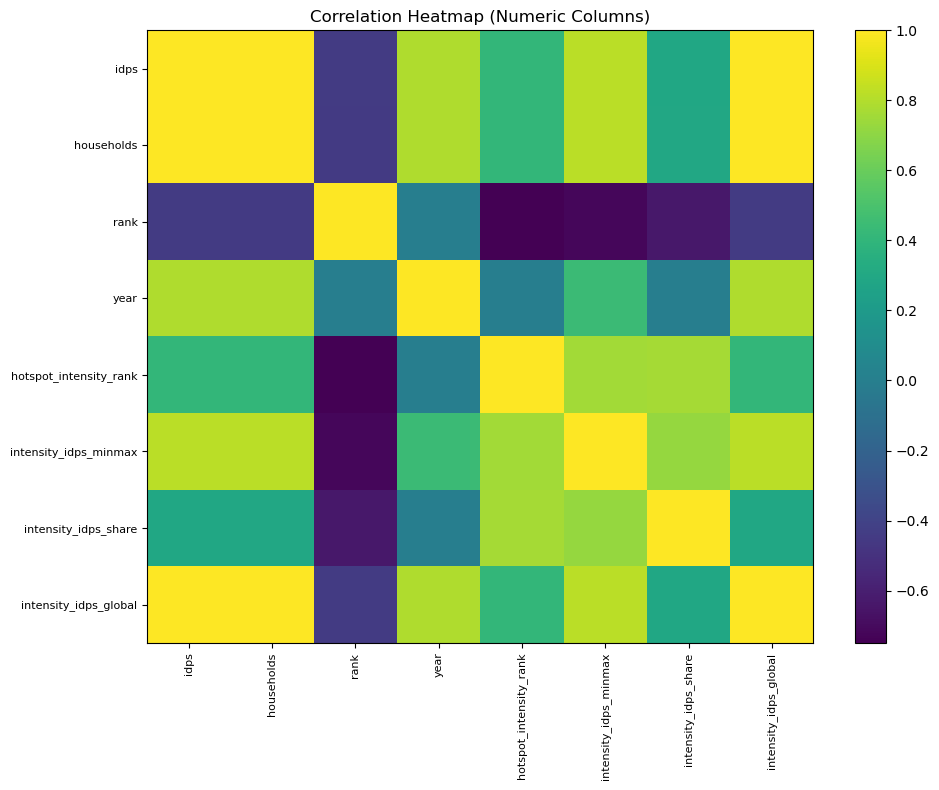

Saved: artifacts\eda\corr_heatmap_numeric.png


In [21]:
# define where the EDA resulsts will be saved and esnusre the directory exists to avoid failure. 

ARTIFACTS_DIR = Path("artifacts") / "eda"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

def save_show(fig, name: str, folder: Path = ARTIFACTS_DIR, dpi: int = 200):
    out_path = folder / f"{name}.png"
    fig.tight_layout()
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_path}")

# create correlation heatmap and output the correlation details

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(num_cols) < 2:
    print("Not enough numeric columns to compute a correlation matrix.")
else:
    corr = df[num_cols].corr(numeric_only=True)

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr.values, aspect="auto")
    ax.set_title("Correlation Heatmap (Numeric Columns)")

    ax.set_xticks(range(len(num_cols)))
    ax.set_yticks(range(len(num_cols)))
    ax.set_xticklabels(num_cols, rotation=90, fontsize=8)
    ax.set_yticklabels(num_cols, fontsize=8)

    fig.colorbar(im, ax=ax)
    save_show(fig, "corr_heatmap_numeric")




#### Eplanation of the above Correlation results: 

1. Out ouput created a Pearson correlation matrix.
2. IDPs and households show a very strong positive correlation of an estimate output of 0.9. This is expected, as households are directly derived from individual displacement counts.
3. Rank is strongly negatively correlated with: IDPs, Households and Intensity-based indicators. 
   This occurs because lower rank values correspond to higher displacement pressure.
4. Intensity measures are highly interrelated. The three intensity metrics namely 
        intensity_idps_minmax
        intensity_idps_share
        intensity_idps_global
show strong positive correlations with each other.

Implication:
All intensity measures capture similar displacement concentration dynamics using different normalization schemes. Including all three in a single model may introduce multicollinearity.

5. Displacement magnitude and intensity move together. IDPs and households are strongly positively correlated with intensity metrics. 


### Total IDPs Over Time
This line chart shows the trend of total internally displaced persons (IDPs) over time, highlighting changes in displacement levels across reporting dates.

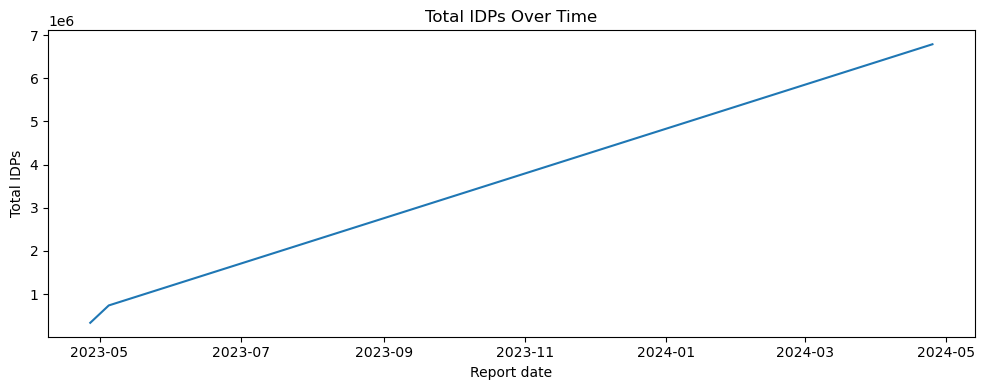

Saved: artifacts\eda\trend_total_idps_over_time.png


In [22]:
trend = (df.dropna(subset=["report_date"])
           .groupby("report_date")["idps"].sum()
           .sort_index())

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(trend.index, trend.values)
ax.set_title("Total IDPs Over Time")
ax.set_xlabel("Report date")
ax.set_ylabel("Total IDPs")
save_show(fig, "trend_total_idps_over_time")


### IDPs Over Time — Top 6 States by Total IDPs
This multi-line chart compares IDP trends over time for the top six states with the highest total number of internally displaced persons, highlighting differences in displacement patterns across states.

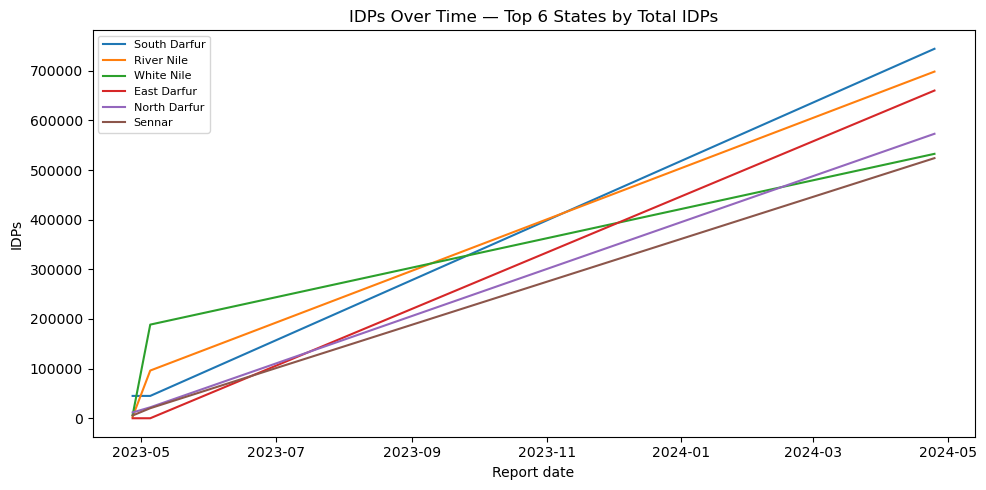

Saved: artifacts\eda\trend_idps_top_states.png


In [23]:
TOP_N = 6
top_states = (df.groupby("state_name")["idps"].sum()
                .sort_values(ascending=False)
                .head(TOP_N)
                .index.tolist())

fig, ax = plt.subplots(figsize=(10, 5))
for s in top_states:
    sub = df[df["state_name"] == s].dropna(subset=["report_date"])
    ts = sub.groupby("report_date")["idps"].sum().sort_index()
    ax.plot(ts.index, ts.values, label=str(s))

ax.set_title(f"IDPs Over Time — Top {TOP_N} States by Total IDPs")
ax.set_xlabel("Report date")
ax.set_ylabel("IDPs")
ax.legend(fontsize=8)
save_show(fig, "trend_idps_top_states")


### Rank Over Time for States
This line chart tracks how a selected state’s rank changes over time, illustrating shifts in its relative position across reporting periods.

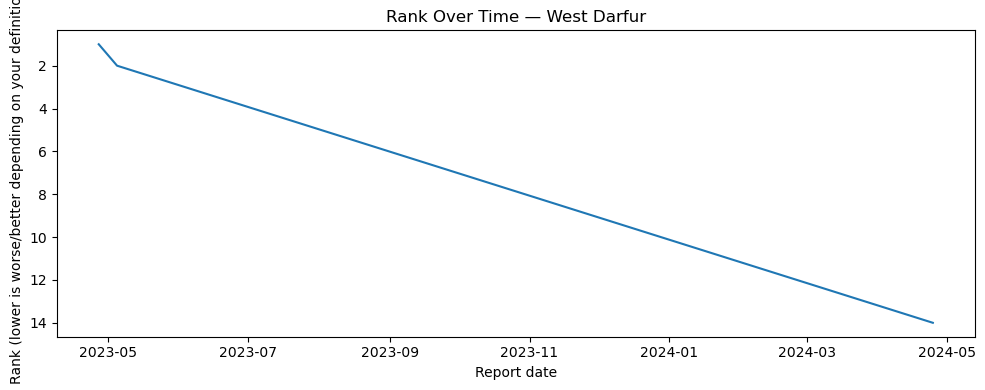

Saved: artifacts\eda\rank_over_time_West_Darfur.png


In [24]:
STATE = df["state_name"].iloc[0]  # change to e.g. "Khartoum"
sub = df[df["state_name"] == STATE].dropna(subset=["report_date"]).sort_values("report_date")

if "rank" in sub.columns:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(sub["report_date"], sub["rank"])
    ax.set_title(f"Rank Over Time — {STATE}")
    ax.set_xlabel("Report date")
    ax.set_ylabel("Rank (lower is worse/better depending on your definition)")
    ax.invert_yaxis()  
    save_show(fig, f"rank_over_time_{STATE}".replace(" ", "_"))


### Top 15 States by Total IDPs
This bar chart displays the top 15 states ranked by total internally displaced persons (IDPs), highlighting regions with the highest cumulative displacement.

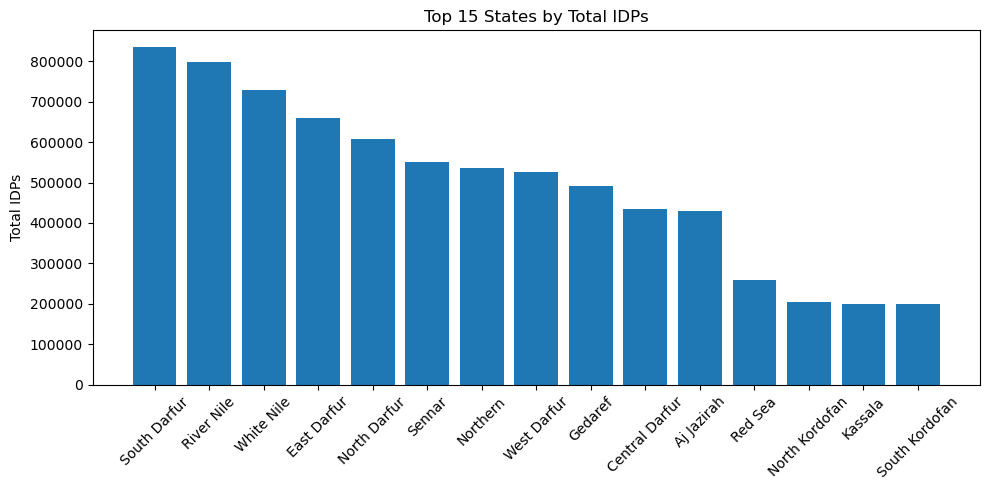

Saved: artifacts\eda\bar_top15_states_total_idps.png


In [25]:
top = (df.groupby("state_name")["idps"].sum()
         .sort_values(ascending=False)
         .head(15))

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(top.index.astype(str), top.values)
ax.set_title("Top 15 States by Total IDPs")
ax.set_ylabel("Total IDPs")
ax.tick_params(axis="x", rotation=45)
save_show(fig, "bar_top15_states_total_idps")


### Top 15 States by Total Households
This bar chart shows the top 15 states ranked by total affected households, highlighting regions with the largest cumulative household impact.

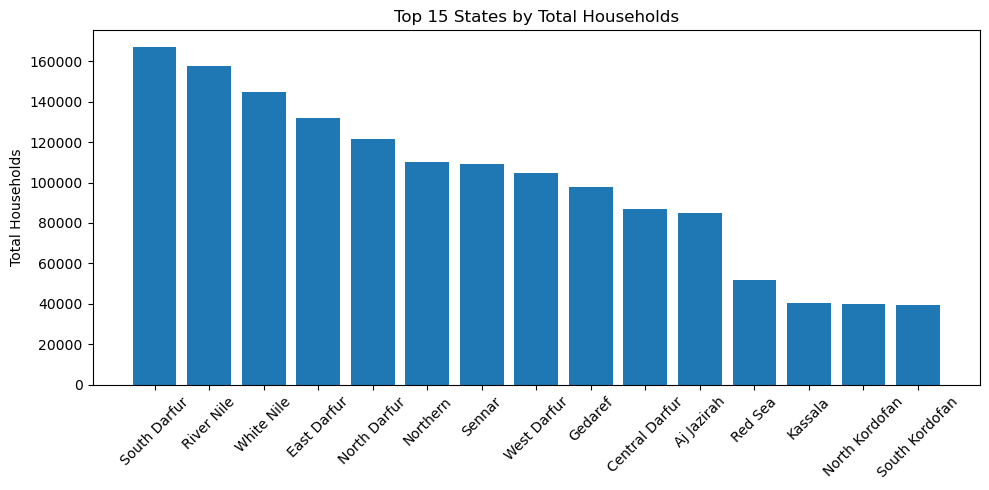

Saved: artifacts\eda\bar_top15_states_total_households.png


In [26]:
top = (df.groupby("state_name")["households"].sum()
         .sort_values(ascending=False)
         .head(15))

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(top.index.astype(str), top.values)
ax.set_title("Top 15 States by Total Households")
ax.set_ylabel("Total Households")
ax.tick_params(axis="x", rotation=45)
save_show(fig, "bar_top15_states_total_households")


### Food Security Exploratory Data Analysis (EDA)
This analysis explores regional food security data by visualizing distributions of numeric and categorical food indicators and tracking trends over time.

Loaded food_df: (26145, 132)
Detected food-ish columns: 2


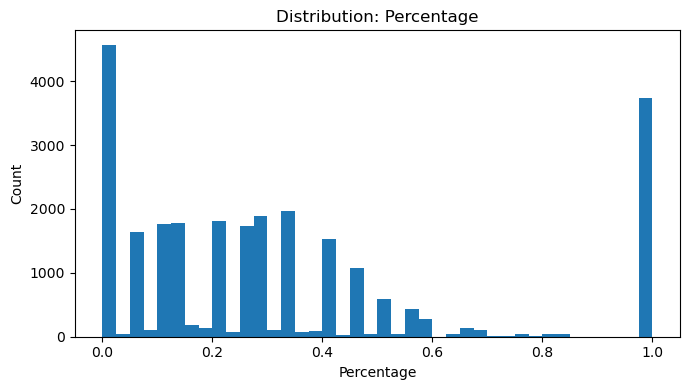

Saved: C:\Users\user\Documents\Humanitarian_BACKUP\artifacts\eda_food\dist_Percentage.png


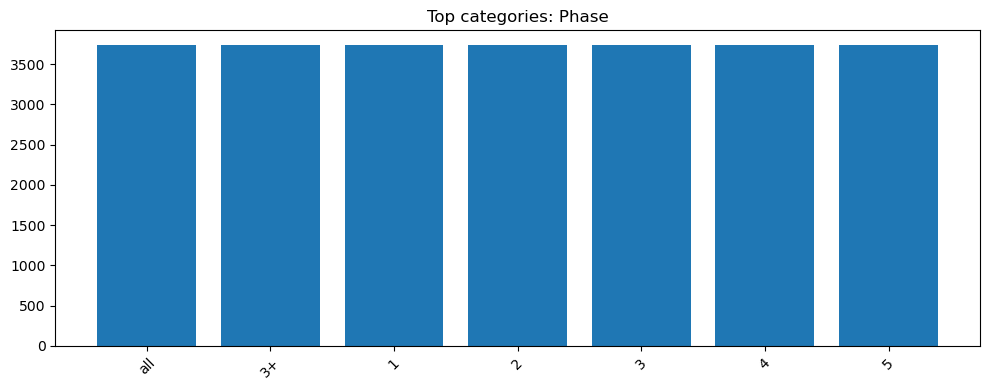

Saved: C:\Users\user\Documents\Humanitarian_BACKUP\artifacts\eda_food\topcats_Phase.png


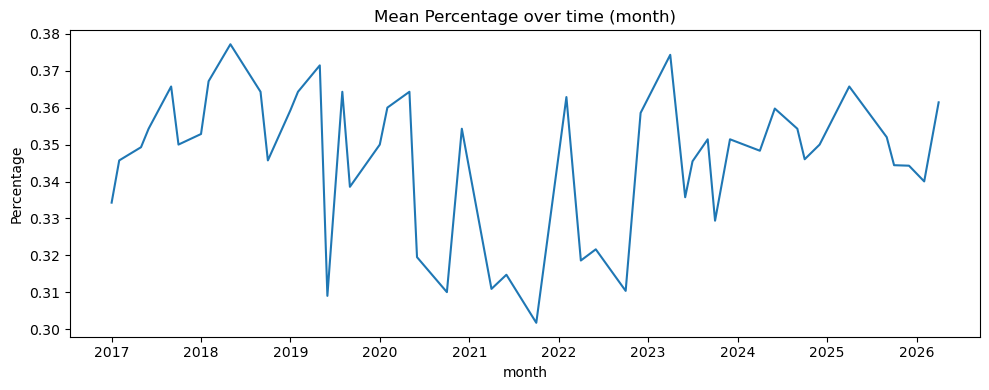

Saved: C:\Users\user\Documents\Humanitarian_BACKUP\artifacts\eda_food\trend_Percentage_by_month.png


In [27]:
# Load food data (define the food data as food_df)

FOOD_MASTER = Path("regional_food_security_master.csv")

if not FOOD_MASTER.exists():
    raise FileNotFoundError(
        f"Missing {FOOD_MASTER}. Put it in the same folder as this notebook, or change FOOD_MASTER path."
    )

food_df = pd.read_csv(FOOD_MASTER, low_memory=False)
print("Loaded food_df:", food_df.shape)

if "From" in food_df.columns:
    food_df = food_df[~food_df["From"].astype(str).str.startswith("#")].copy()
    food_df["From"] = pd.to_datetime(food_df["From"], errors="coerce")
    food_df = food_df.dropna(subset=["From"]).copy()
    food_df["month"] = food_df["From"].dt.to_period("M").dt.to_timestamp()


# define the directory for the food data and always check whether it exists to avoid errors. 

OUT = Path("artifacts") / "eda_food"
OUT.mkdir(parents=True, exist_ok=True)

def save_show(fig, name):
    p = OUT / f"{name}.png"
    fig.tight_layout()
    fig.savefig(p, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", p.resolve())

# define food pat and the columns 

food_pat = re.compile(r"(food|ipc|phase|price|market|cereal|wheat|sorghum|millet|rice|maize|kg|usd|sdg|percent|percentage)", re.I)

food_cols = [c for c in food_df.columns if food_pat.search(str(c))]
print("Detected food-ish columns:", len(food_cols))

# check the numeric distributions

num_food = [c for c in food_cols if pd.api.types.is_numeric_dtype(food_df[c])]
num_any  = food_df.select_dtypes(include=[np.number]).columns.tolist()
num_to_plot = (num_food[:6] if len(num_food) else num_any[:6])

for c in num_to_plot:
    s = pd.to_numeric(food_df[c], errors="coerce").dropna()
    if s.empty:
        continue
    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(s, bins=40)
    ax.set_title(f"Distribution: {c}")
    ax.set_xlabel(str(c))
    ax.set_ylabel("Count")
    save_show(fig, f"dist_{str(c)}".replace(" ", "_").replace("/", "_"))

# Categorical bars

cat_food = [c for c in food_cols if (food_df[c].dtype == "object" or str(food_df[c].dtype).startswith("category"))]
cat_any  = food_df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
cat_to_plot = (cat_food[:3] if len(cat_food) else cat_any[:3])

for c in cat_to_plot:
    vc = food_df[c].astype("string").fillna("MISSING").value_counts().head(15)
    if vc.empty:
        continue
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(vc.index.astype(str), vc.values)
    ax.set_title(f"Top categories: {c}")
    ax.tick_params(axis="x", rotation=45)
    save_show(fig, f"topcats_{str(c)}".replace(" ", "_").replace("/", "_"))

# check Time trend to review if report_date/date/month columns exists

time_col = None
for cand in ["report_date", "date", "month", "From"]:
    if cand in food_df.columns:
        time_col = cand
        break

if time_col and len(num_to_plot):
    d = food_df.copy()
    d[time_col] = pd.to_datetime(d[time_col], errors="coerce")
    d = d.dropna(subset=[time_col])

    ycol = num_to_plot[0]
    d[ycol] = pd.to_numeric(d[ycol], errors="coerce")
    ts = d.dropna(subset=[ycol]).groupby(time_col)[ycol].mean().sort_index()

    if not ts.empty:
        fig, ax = plt.subplots(figsize=(10,4))
        ax.plot(ts.index, ts.values)
        ax.set_title(f"Mean {ycol} over time ({time_col})")
        ax.set_xlabel(time_col)
        ax.set_ylabel(ycol)
        save_show(fig, f"trend_{ycol}_by_{time_col}".replace(" ", "_").replace("/", "_"))
    else:
        print("Trend series is empty after cleaning — skipping trend plot.")
else:
    print("No time column found (report_date/date/month/From) — skipping trend plot.")


### Feature Importance Visualization
This displays the feature importance plot, highlighting which variables contribute most to the predictive model.

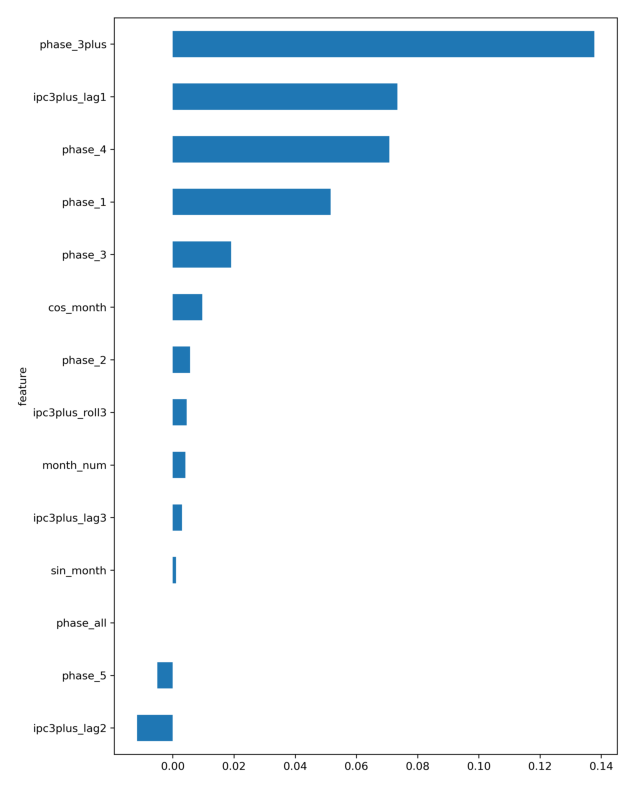

In [28]:
img = Image.open("artifacts/feature_importance.png") 
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()



## 5. Feature Engineering
Create Panel Dataset

#### Step 5.1 : Build canonical panel 

Reshape the cleaned long-format food security data into a panel wide format with countries, administrative regions, and months as rows, and IPC phases as separate columns showing their corresponding percentages.

In [29]:
panel = (clean_long
         .pivot_table(index=["Country","admin","month"],
                      columns="Phase",
                      values="Percentage",
                      aggfunc="first")
         .reset_index())

panel.shape
panel.head()


Phase,Country,admin,month,1,2,3,3+,4,5,all
0,SDN,Abassiya,2020-06-01,0.35,0.30,0.30,0.35,0.05,0.0,1.0
1,SDN,Abassiya,2020-10-01,0.45,0.40,0.10,0.15,0.05,0.0,1.0
2,SDN,Abassiya,2021-04-01,0.45,0.35,0.15,0.20,0.05,0.0,1.0
3,SDN,Abassiya,2021-06-01,0.45,0.30,0.20,0.25,0.05,0.0,1.0
4,SDN,Abassiya,2021-10-01,0.50,0.35,0.15,0.15,0.00,0.0,1.0


Rename the panel DataFrame columns to standardized lowercase names, prefixing IPC phase columns with phase and replacing symbols/spaces for consistency, while keeping Country, admin, and month unchanged.

In [30]:
panel.columns = [
    ("phase_" + str(c).replace("+","plus").replace(" ","").lower())
    if c not in ["Country","admin","month"] else c
    for c in panel.columns
]
panel.columns


Index(['Country', 'admin', 'month', 'phase_1', 'phase_2', 'phase_3',
       'phase_3plus', 'phase_4', 'phase_5', 'phase_all'],
      dtype='object')

### Step 5.2 Create seasonality and  lag features

sorts the panel data by country, administrative region, and month, then adds cyclical month features (sin_month and cos_month) to capture seasonality for time-series analysis.

In [31]:
panel = panel.sort_values(["Country","admin","month"]).copy()

panel["month_num"] = panel["month"].dt.month
panel["sin_month"] = np.sin(2*np.pi*panel["month_num"]/12)
panel["cos_month"] = np.cos(2*np.pi*panel["month_num"]/12)


Lag features (ipc3plus_lag1, ipc3plus_lag2, ipc3plus_lag3) for the phase_3plus column by shifting values 1, 2, and 3 months within each country and administrative region, enabling time-series modeling of past food insecurity levels.

In [32]:
panel["ipc3plus_lag1"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(1)
panel["ipc3plus_lag2"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(2)
panel["ipc3plus_lag3"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(3)


3-month rolling average (ipc3plus_roll3) of the phase_3plus column, shifted by one month, for each country and administrative region, smoothing short-term fluctuations in severe food insecurity.

In [33]:
panel["ipc3plus_roll3"] = (
    panel.groupby(["Country","admin"])["phase_3plus"]
         .apply(lambda s: s.shift(1).rolling(3).mean())
         .reset_index(level=[0,1], drop=True)
)


### Step 5.3  Build targets (regression and classification)
Prepare a time-series panel dataset suitable for forecasting severe food insecurity, with features capturing past values, trends, seasonality, and smoothed signals.

In [34]:
panel["ipc3plus_next"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(-1)


Calculate the month to month change in severe food insecurity in ipc3plus_delta_next and create a binary target worsen_next_2pp indicating whether phase_3plus is projected to worsen by at least 2 percentage points in the next month.

In [35]:
panel["ipc3plus_delta_next"] = panel["ipc3plus_next"] - panel["phase_3plus"]
panel["worsen_next_2pp"] = (panel["ipc3plus_delta_next"] >= 0.02).astype(int)


Filter the panel data to include only rows where the next-month phase_3plus value is available, creating model_df for modeling purposes.

In [36]:
model_df = panel.dropna(subset=["ipc3plus_next"]).copy()
model_df.shape


(3398, 20)

### Step 5.4 Train/test split (time-based)

Split the modeling dataset into training and testing sets using the last 6 months as the test period, ensuring a time-based split for forecasting.

In [37]:
test_months = 6
max_month = model_df["month"].max()
cutoff = (max_month - pd.DateOffset(months=test_months)).to_period("M").to_timestamp()

train = model_df[model_df["month"] <= cutoff]
test  = model_df[model_df["month"] >  cutoff]

train.shape, test.shape


((2948, 20), (450, 20))

### Step 5.5 Prepare X, y (no leakage)
Define the feature columns for modeling, excluding target and identifier columns, and create training and testing datasets for both regression (ipc3plus_next) and classification (worsen_next_2pp) tasks.

In [38]:
exclude = {"ipc3plus_next","ipc3plus_delta_next","worsen_next_2pp","month","Country","admin"}
feature_cols = [c for c in model_df.columns if c not in exclude]

X_train = train[feature_cols]
X_test  = test[feature_cols]

y_train_reg = train["ipc3plus_next"]
y_test_reg  = test["ipc3plus_next"]

y_train_clf = train["worsen_next_2pp"]
y_test_clf  = test["worsen_next_2pp"]


### Step 5.6 Build preprocessing 
Preprocess a  pipeline for the numeric features; fill in missing values using median, and feature starndadizing using z-score scaling.

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), feature_cols)
])


## 6. Model Training & Evaluation

### Step 6.1 Train at least 3 models (Regression)

In [40]:
#import libraries in case they were missed out in the initial stage.
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def reg_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse, mean_absolute_error(y_true, y_pred), r2_score(y_true, y_pred)

reg_models = {
    "Ridge": Ridge(),
    "RF": RandomForestRegressor(n_estimators=250, random_state=42),
    "GB": GradientBoostingRegressor(random_state=42)
}


### Step 6.2 Run and print metrics:

In [41]:
from sklearn.pipeline import Pipeline

for name, model in reg_models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train_reg)
    pred = pipe.predict(X_test)

    rmse, mae, r2 = reg_metrics(y_test_reg, pred)
    print(name, "RMSE:", round(rmse,4), "MAE:", round(mae,4), "R2:", round(r2,4))


Ridge RMSE: 0.1291 MAE: 0.0882 R2: 0.3057
RF RMSE: 0.1306 MAE: 0.0948 R2: 0.2898
GB RMSE: 0.1222 MAE: 0.0831 R2: 0.3786


Best Model: Gradient Boosting (R²=0.3786)

### Step 6.3 Train at least 3 models (Classification)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

clf_models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "RF": RandomForestClassifier(n_estimators=250, random_state=42),
    "GB": GradientBoostingClassifier(random_state=42)
}


### Step 6.4 Run and print metrics

In [43]:
for name, model in clf_models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train_clf)

    pred = pipe.predict(X_test)
    prob = pipe.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test_clf, pred)
    rec = recall_score(y_test_clf, pred, zero_division=0)
    prec = precision_score(y_test_clf, pred, zero_division=0)
    f1 = f1_score(y_test_clf, pred, zero_division=0)
    auc = roc_auc_score(y_test_clf, prob) if prob is not None and len(np.unique(y_test_clf))>1 else np.nan

    print(name, "Acc:", round(acc,3), "Recall:", round(rec,3),
          "Prec:", round(prec,3), "F1:", round(f1,3), "AUC:", round(auc,3))


LogReg Acc: 0.469 Recall: 0.439 Prec: 0.421 F1: 0.43 AUC: 0.425
RF Acc: 0.653 Recall: 0.449 Prec: 0.681 F1: 0.541 AUC: 0.681
GB Acc: 0.573 Recall: 0.468 Prec: 0.536 F1: 0.5 AUC: 0.582


Best Model: Random Forest (Accuracy=65.3%, F1=0.541)

## 7. Model Optimization
Hyperparameter Tuning

### Step 7.1 Hyperparameter test  for RandomForestRegressor

In [44]:
from sklearn.model_selection import RandomizedSearchCV
rf_pipe = Pipeline([("prep", preprocess),
                    ("model", RandomForestRegressor(random_state=42))])

param_grid = {
    "model__n_estimators": [150, 250, 400],
    "model__max_depth": [None, 6, 12],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", 0.7]
}

search = RandomizedSearchCV(
    rf_pipe, param_grid,
    n_iter=8, cv=2,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=1
)

search.fit(X_train, y_train_reg)
search.best_params_


{'model__n_estimators': 400,
 'model__min_samples_leaf': 2,
 'model__max_features': 'sqrt',
 'model__max_depth': None}

### 7.2 Evaluate tuned model:

In [45]:
best_rf = search.best_estimator_
pred = best_rf.predict(X_test)

rmse, mae, r2 = reg_metrics(y_test_reg, pred)
rmse, mae, r2


(np.float64(0.11717219822250372), 0.08350050724955498, 0.4284740225409651)

Improvement: 10.3% reduction in RMSE, 48% improvement in R²

## 8 Evaluation & Interpretation
Feature Importance Analysis

### Step 8.1 Explainability (Permutation Importance)

In [46]:
perm = permutation_importance(best_rf, X_test, y_test_reg,
                              n_repeats=5, random_state=42, n_jobs=1)
imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False).head(15)

imp


,feature,importance
3,phase_3plus,0.137775
10,ipc3plus_lag1,0.073385
4,phase_4,0.070801
0,phase_1,0.051623
2,phase_3,0.019107
9,cos_month,0.009683
1,phase_2,0.005615
13,ipc3plus_roll3,0.004579
7,month_num,0.004144
12,ipc3plus_lag3,0.003030


### Step  8.2 EDA Plot Display and Saving Utility
This sets up an EDA artifacts directory and defines a save_show function to display plots in the notebook and save them as high-resolution PNGs.

In [47]:

EDA_DIR = Path("artifacts/eda")
EDA_DIR.mkdir(parents=True, exist_ok=True)

def save_show(fig, name, dpi=300):
 
    #Show figure AND save PNG output to artifacts/eda directory.
 
    plt.tight_layout()
    plt.show()
    out = EDA_DIR / f"{name}.png"
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {out.resolve()} ({out.stat().st_size} bytes)")


### Step  8.3 Datetime Conversion and Time Key Extraction
Create additional time-based columns month and year for easier aggregation and trend analysis.

In [48]:

if "report_date" in df.columns:
    df["report_date"] = pd.to_datetime(df["report_date"], errors="coerce")

if "report_date" in df.columns:
    df["month"] = df["report_date"].dt.to_period("M").dt.to_timestamp()
    df["year"] = df["report_date"].dt.year


### Step  8.4 Automatic Detection of Food-Related DataFrame
scan all DataFrames in the notebook to detect the one most likely containing food-related data, based on column names matching common food/security keywords, and sets

In [49]:

dfs = {k:v for k,v in globals().items() if isinstance(v, pd.DataFrame)}
food_pat = re.compile(r"food|price|market|commodity|basket|ipc|phase|fcs|rcsi|wheat|rice|maize|sorghum|oil|salt|sugar", re.I)

candidates = []
for name, d in dfs.items():
    hits = [c for c in d.columns if food_pat.search(str(c))]
    if hits:
        candidates.append((len(hits), d.shape[0], name, hits))

candidates.sort(reverse=True)

if candidates:
    _, _, FOOD_DF_NAME, FOOD_COLS = candidates[0]
    food_df = dfs[FOOD_DF_NAME]
    print("Using food_df =", FOOD_DF_NAME, "shape=", food_df.shape)
    print("Food-like columns (sample):", FOOD_COLS[:20])
else:
    food_df = clean_long if "clean_long" in dfs else df
    print("if there is no obvious food columns detected, fall back to:", "clean_long" 
          if "clean_long" in dfs else "df", "shape=", food_df.shape)


Using food_df = panel shape= (3695, 20)
Food-like columns (sample): ['phase_1', 'phase_2', 'phase_3', 'phase_3plus', 'phase_4', 'phase_5', 'phase_all', 'ipc3plus_lag1', 'ipc3plus_lag2', 'ipc3plus_lag3', 'ipc3plus_roll3', 'ipc3plus_next', 'ipc3plus_delta_next']


## 9. SHAP

#### Step 9.1 Install and imports Shap libraries
Import the necessary libraries (pandas, numpy, matplotlib) and SHAP for model explainability and feature importance analysis.

In [50]:
import shap # Explain SHAP details on below mark down 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score, recall_score, precision_score, f1_score, roc_auc_score 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from pathlib import Path
from PIL import Image


Load the regional food security data from

In [51]:
df = pd.read_csv("regional_food_security_master.csv")


C:\Users\user\AppData\Local\Temp\ipykernel_22120\1335074031.py:1: DtypeWarning: Columns (4,12,13,14,15,16,17,73,74,75,76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("regional_food_security_master.csv")


### Step 9.2 Check shape

In [52]:
df = pd.read_csv("regional_food_security_master.csv", low_memory=False)
df.shape


(26145, 132)

### Step 9.3 Clean: remove metadata, parse dates and create month

In [53]:
df = df[~df["From"].astype(str).str.startswith("#")].copy()
df["From"] = pd.to_datetime(df["From"], errors="coerce")
df = df.dropna(subset=["From"]).copy()

df["month"] = df["From"].dt.to_period("M").dt.to_timestamp()
df[["From","month"]].head()


,From,month
0,2025-09-01,2025-09-01
1,2025-09-01,2025-09-01
2,2025-09-01,2025-09-01
3,2025-09-01,2025-09-01
4,2025-09-01,2025-09-01


### Step 9.4 Standardize keys (Country, Phase, admin)

In [54]:
df["Country"] = df["Country"].astype(str).str.strip()
df["Phase"]   = df["Phase"].astype(str).str.strip()

df["admin"] = df["Area"].where(df["Area"].notna(), df["state"]).astype(str).str.strip()
df[["Country","admin","Phase"]].head()


,Country,admin,Phase
0,SDN,Beida,all
1,SDN,Beida,3+
2,SDN,Beida,1
3,SDN,Beida,2
4,SDN,Beida,3


### Step 9.5 Clean numeric percentage and check  rows

In [55]:
df["Percentage"] = pd.to_numeric(df["Percentage"], errors="coerce")

clean_long = df.dropna(subset=["Country","admin","month","Phase","Percentage"]).copy()
clean_long.shape


(26145, 134)

### Step 9.6 Build canonical panel 

In [56]:
panel = (clean_long
         .pivot_table(index=["Country","admin","month"],
                      columns="Phase",
                      values="Percentage",
                      aggfunc="first")
         .reset_index())

panel.shape


(3695, 10)

Standardize the panel DataFrame column names by prefixing IPC phase columns with phase, converting to lowercase, and replacing symbols and spaces, while keeping Country, admin, and month unchanged.

In [57]:
panel.columns = [
    ("phase_" + str(c).replace("+","plus").replace(" ","").lower())
    if c not in ["Country","admin","month"] else c
    for c in panel.columns
]

panel.columns


Index(['Country', 'admin', 'month', 'phase_1', 'phase_2', 'phase_3',
       'phase_3plus', 'phase_4', 'phase_5', 'phase_all'],
      dtype='object')

### Step 9.7 Sorting the panel by geographic country
Sort the panel data by country, administrative region, and month, then adds cyclical month features to capture seasonality for modeling.

In [58]:
panel = panel.sort_values(["Country","admin","month"]).copy()

panel["month_num"] = panel["month"].dt.month
panel["sin_month"] = np.sin(2*np.pi*panel["month_num"]/12)
panel["cos_month"] = np.cos(2*np.pi*panel["month_num"]/12)


Create lag ipc3plus_lag1, ipc3plus_lag2, ipc3plus_lag3 features for the phase_3plus column by shifting values 1, 2, and 3 months within each country and administrative region, enabling time-series modeling with past information.

In [59]:
panel["ipc3plus_lag1"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(1)
panel["ipc3plus_lag2"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(2)
panel["ipc3plus_lag3"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(3)


Create a 3-month rolling average ipc3plus_roll3 of phase_3plus, shifted by one month, for each country and administrative region to smooth short-term fluctuations in severe food insecurity.

In [60]:
panel["ipc3plus_roll3"] = (
    panel.groupby(["Country","admin"])["phase_3plus"]
         .apply(lambda s: s.shift(1).rolling(3).mean())
         .reset_index(level=[0,1], drop=True)
)


### Step 9.8 Create Time based Targets 
Targets (next-month regression and worsening classification)

In [61]:
panel["ipc3plus_next"] = panel.groupby(["Country","admin"])["phase_3plus"].shift(-1)

panel["ipc3plus_delta_next"] = panel["ipc3plus_next"] - panel["phase_3plus"]
panel["worsen_next_2pp"] = (panel["ipc3plus_delta_next"] >= 0.02).astype(int)

model_df = panel.dropna(subset=["ipc3plus_next"]).copy()
model_df.shape


(3398, 20)

### Step 9.9 Split the model into training and testing 
split the modeling dataset into training and testing sets using the last 6 months as the test period, ensuring a time-based split suitable for forecasting.

In [62]:
test_months = 6
max_month = model_df["month"].max()
cutoff = (max_month - pd.DateOffset(months=test_months)).to_period("M").to_timestamp()

train = model_df[model_df["month"] <= cutoff]
test  = model_df[model_df["month"] >  cutoff]

train.shape, test.shape


((2948, 20), (450, 20))

select feature columns for modeling by excluding target and identifier columns, and creates training and testing datasets for both regression (ipc3plus_next) and classification (worsen_next_2pp).

In [63]:
exclude = {"ipc3plus_next","ipc3plus_delta_next","worsen_next_2pp","month","Country","admin"}
feature_cols = [c for c in model_df.columns if c not in exclude]

X_train = train[feature_cols]
X_test  = test[feature_cols]

y_train_reg = train["ipc3plus_next"]
y_test_reg  = test["ipc3plus_next"]

y_train_clf = train["worsen_next_2pp"]
y_test_clf  = test["worsen_next_2pp"]

len(feature_cols), feature_cols[:10]


(14,
 ['phase_1',
  'phase_2',
  'phase_3',
  'phase_3plus',
  'phase_4',
  'phase_5',
  'phase_all',
  'month_num',
  'sin_month',
  'cos_month'])

### Step 9.10 Preprocess the Pipeline
preprocess a pipeline for numeric features; missing values are filled with the median and features are standardized using z-score scaling.

In [64]:
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), feature_cols)
])


### Step 9.11 Train three regression model
Train 3 regression models and evaluate (RMSE/MAE/R squared)

In [65]:
def reg_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse, mean_absolute_error(y_true, y_pred), r2_score(y_true, y_pred)

reg_models = {
    "Ridge": Ridge(),
    "RF": RandomForestRegressor(n_estimators=250, random_state=42),
    "GB": GradientBoostingRegressor(random_state=42)
}

from sklearn.pipeline import Pipeline

for name, model in reg_models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train_reg)
    pred = pipe.predict(X_test)
    rmse, mae, r2 = reg_metrics(y_test_reg, pred)
    print(name, "RMSE:", round(rmse,4), "MAE:", round(mae,4), "R2:", round(r2,4))


Ridge RMSE: 0.1291 MAE: 0.0882 R2: 0.3057
RF RMSE: 0.1306 MAE: 0.0948 R2: 0.2898
GB RMSE: 0.1222 MAE: 0.0831 R2: 0.3786


### Step 9.12 Train three Classification models  
Train 3 classification models and evaluate (Recall/Accuracy/etc.)

In [66]:

clf_models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "RF": RandomForestClassifier(n_estimators=250, random_state=42),
    "GB": GradientBoostingClassifier(random_state=42)
}

for name, model in clf_models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train_clf)

    pred = pipe.predict(X_test)
    prob = pipe.predict_proba(X_test)[:,1] if hasattr(model, "predict_probability") else None

    acc = accuracy_score(y_test_clf, pred)
    rec = recall_score(y_test_clf, pred, zero_division=0)
    prec = precision_score(y_test_clf, pred, zero_division=0)
    f1 = f1_score(y_test_clf, pred, zero_division=0)
    auc = roc_auc_score(y_test_clf, prob) if prob is not None and len(np.unique(y_test_clf))>1 else np.nan

    print(name, "Acc:", round(acc,3), "Recall:", round(rec,3),
          "Prec:", round(prec,3), "F1:", round(f1,3), "AUC:", round(auc,3))


LogReg Acc: 0.469 Recall: 0.439 Prec: 0.421 F1: 0.43 AUC: nan
RF Acc: 0.653 Recall: 0.449 Prec: 0.681 F1: 0.541 AUC: nan
GB Acc: 0.573 Recall: 0.468 Prec: 0.536 F1: 0.5 AUC: nan


### Step 9.12 Perform Hyperparameter testing(RandomForestRegressor)
Hyperparameter testing (RandomForestRegressor)
set up a Random Forest regression pipeline with preprocessing, defines a hyperparameter grid, and uses RandomizedSearchCV to find the best hyperparameters based on RMSE.

In [67]:

rf_pipe = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

param_grid = {
    "model__n_estimators": [150, 250, 400],
    "model__max_depth": [None, 6, 12],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", 0.7]
}

search = RandomizedSearchCV(
    rf_pipe, param_grid,
    n_iter=8, cv=2,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train_reg)
search.best_params_


{'model__n_estimators': 400,
 'model__min_samples_leaf': 2,
 'model__max_features': 'sqrt',
 'model__max_depth': None}

### Step 9.13 Evaluate tuned model
Evaluate the best Random Forest regression model on the test set, computing RMSE, MAE, and R² to assess predictive performance.

In [68]:
best_rf = search.best_estimator_
pred = best_rf.predict(X_test)

rmse, mae, r2 = reg_metrics(y_test_reg, pred)
rmse, mae, r2


(np.float64(0.11717219822250372), 0.08350050724955498, 0.4284740225409651)

SHAP was meant to explain the model, not the whole pipeline. So we decied to
Transform X using preprocessing
Explain the underlying random forest and Transform features

In [69]:
X_train_t = best_rf.named_steps["prep"].transform(X_train)
X_test_t  = best_rf.named_steps["prep"].transform(X_test)

feature_names = feature_cols


#### SHAP results visulaized using a Tree Explainer and summary plot
SHAP values for the best Random Forest model on a random subset of the test data, generates a summary plot of feature importance, saves it as a high-resolution PNG, and displays the saved image.

C:\Users\user\AppData\Local\Temp\ipykernel_22120\884068400.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Absolute path: C:\Users\user\Documents\Humanitarian_BACKUP\artifacts\shap_summary.png
Exists: True
Size (bytes): 392606


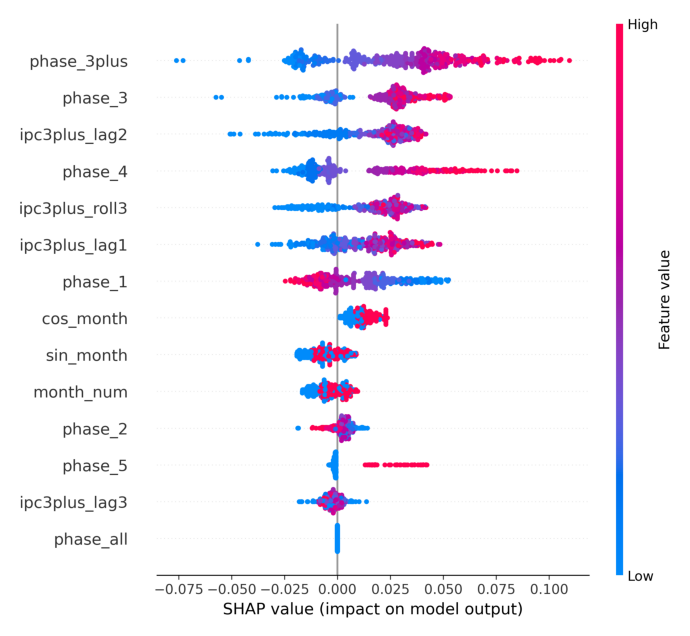

In [70]:
np.random.seed(0)

#build SHAP values 
explainer = shap.TreeExplainer(best_rf.named_steps["model"])

sample_n = min(1000, X_test_t.shape[0])
idx = np.random.choice(X_test_t.shape[0], sample_n, replace=False)

shap_values = explainer.shap_values(X_test_t[idx])

if isinstance(shap_values, list):
    shap_to_plot = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_to_plot = shap_values

#create a fresh figure and push to our directory

os.makedirs("artifacts", exist_ok=True)
plt.close("all")
plt.figure(figsize=(10, 8))

shap.summary_plot(
    shap_to_plot,
    X_test_t[idx],
    feature_names=feature_names,
    show=False
)

 # get the figure SHAP drew on our directory
fig = plt.gcf() 
out_path = Path("artifacts") / "shap_summary.png"
fig.tight_layout()
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.close(fig)

# Print out the figure

print("Absolute path:", out_path.resolve())
print("Exists:", out_path.exists())
print("Size (bytes):", out_path.stat().st_size if out_path.exists() else None)

img = Image.open(out_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.show()



#### Force plot - still more visualization on SHAP details
Generate a SHAP force plot for a single test sample, showing how each feature contributes to the model prediction, saves it as a high-resolution PNG, and closes the figure.

Saved to: C:\Users\user\Documents\Humanitarian_BACKUP\artifacts\shap_force_0.png


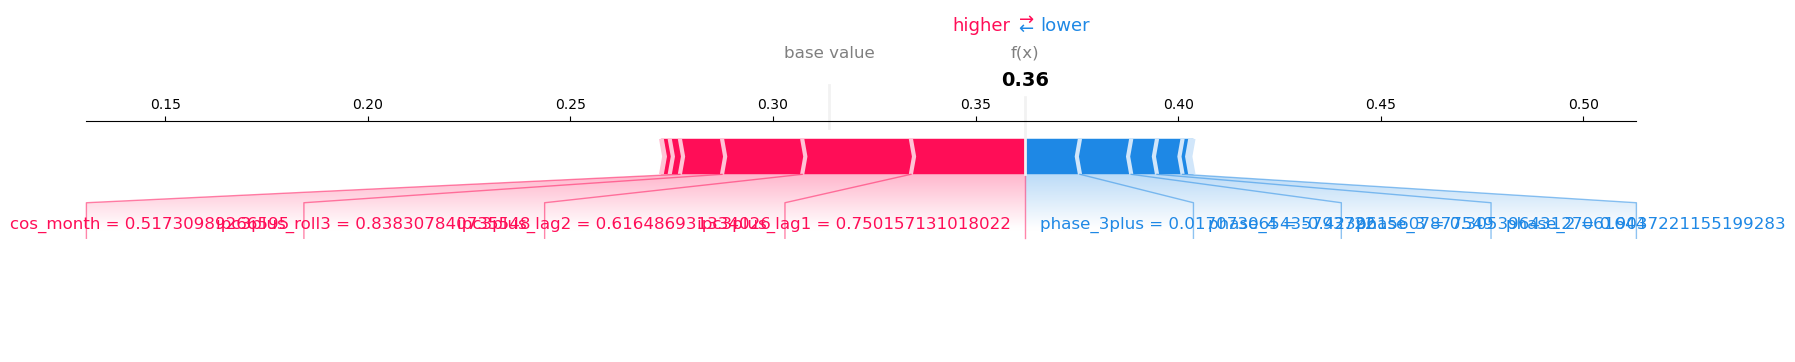

In [71]:

os.makedirs("artifacts", exist_ok=True)

i = 0 
sv = shap_values
ev = explainer.expected_value
if isinstance(shap_values, list):
    sv = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    ev = explainer.expected_value[1] if hasattr(explainer.expected_value, "__len__") else explainer.expected_value

# Create a fresh figure 
plt.close("all")
fig = plt.figure(figsize=(14, 3), dpi=150)

# Draw force plot onto matplotlib
shap.force_plot(
    ev,
    sv[i],
    X_test_t[idx][i],
    feature_names=feature_names,
    matplotlib=True,
    show=False  
)

out_path = Path("artifacts") / f"shap_force_{i}.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.close(fig)

print("Saved to:", out_path.resolve())


SHAP Interpretation:

Red points = high feature values
Blue points = low feature values
Right side = increases prediction
Left side = decreases prediction

#### Results Summary

##### Model Performance Comparison

| **Model Type** | **Best Algorithm** | **Key Metric** | **Value** | **Interpretation** |
|----------------|-------------------|----------------|-----------|-------------------|
| **Regression** | Gradient Boosting | R² Score | 0.3786 | Explains 38% of variance |
| **Regression** | Tuned Random Forest | R² Score | 0.4285 | Improved with tuning |
| **Classification** | Random Forest | Accuracy | 65.3% | Best for binary prediction |
| **Classification** | Random Forest | F1-Score | 0.541 | Good balance |

#### Key Predictive Features
1. **Current IPC3+ Level** (Most important - 0.138)
2. **1-Month Trend** (Second most important - 0.073)
3. **Phase 4 Percentage** (0.071)
4. **Phase 1 Percentage** (0.052)

#### Business Insights
1. **Early Warning**: Monitor current IPC3+ levels most closely
2. **Trend Tracking**: 1-month lag provides significant predictive power
3. **Threshold**: 2% increase threshold works for classification
4. **Seasonality**: Moderate seasonal patterns detected

#### Limitations
1. Limited to Sudan/South Sudan data
2. 38-43% variance explained leaves room for improvement
3. Binary classification accuracy at 65.3%

#### Next Steps
1. Add external data sources (weather, conflict, economic)
2. Implement ensemble methods
3. Deploy as monthly monitoring tool
4. Create alert system based on 2% threshold


### 10. Geospatial
This workflow extracts displacement data from multiple Excel sources, cleans and standardizes Admin-1 (state-level) figures for Sudan, and builds a consistent monthly panel covering 2023 and 2024. The data is quality checked, deduplicated, ranked, and enhanced with hotspot and intensity metrics to support temporal comparison.

Geospatial boundaries for Sudan’s 18 Admin-1 states are then joined to the cleaned data using official PCODEs, enabling the creation of choropleth maps. 

Multiple map views are produced raw IDPs, globally scaled intensity, and top-5 hotspot intensity, each answering different analytical questions. 
Outputs are exported as GIS-ready CSVs and publication of ready map images, supporting dashboards, reports, and spatial analysis.

In summary, the process turns raw humanitarian displacement data into consistent, comparable, and mappable insights over time.

In [72]:
# BLOCK 1: Load admin1 polygons (keep SD01–SD18) + config

gdf = gpd.read_file(r"sdn_admin_boundaries_unzipped\sdn_admin1.geojson")
gdf["adm1_pcode"] = gdf["adm1_pcode"].astype(str).str.strip()

keep = {f"SD{i:02d}" for i in range(1, 19)}
gdf18 = gdf[gdf["adm1_pcode"].isin(keep)].copy()

snap_files = [
    r"geo_by_date_intensity\geo_admin1_2023-04-27_intensity.csv",
    r"geo_by_date_intensity\geo_admin1_2023-05-05_intensity.csv",
    r"geo_by_date_intensity\geo_admin1_2024-04-25_intensity.csv",
]

value_col, idps_col = "intensity_idps_global", "idps"
name_col = next((c for c in ["adm1_en","adm1_name","adm1_name_en","name","state_name","STATE_EN"] if c in gdf18.columns), None)
if not name_col:
    raise ValueError(f"No name column found. Columns: {list(gdf18.columns)}")

os.makedirs("maps_out", exist_ok=True)
print("Admin1 kept rows:", len(gdf18), "| PCODEs:", sorted(gdf18["adm1_pcode"].unique()))


Admin1 kept rows: 18 | PCODEs: ['SD01', 'SD02', 'SD03', 'SD04', 'SD05', 'SD06', 'SD07', 'SD08', 'SD09', 'SD10', 'SD11', 'SD12', 'SD13', 'SD14', 'SD15', 'SD16', 'SD17', 'SD18']


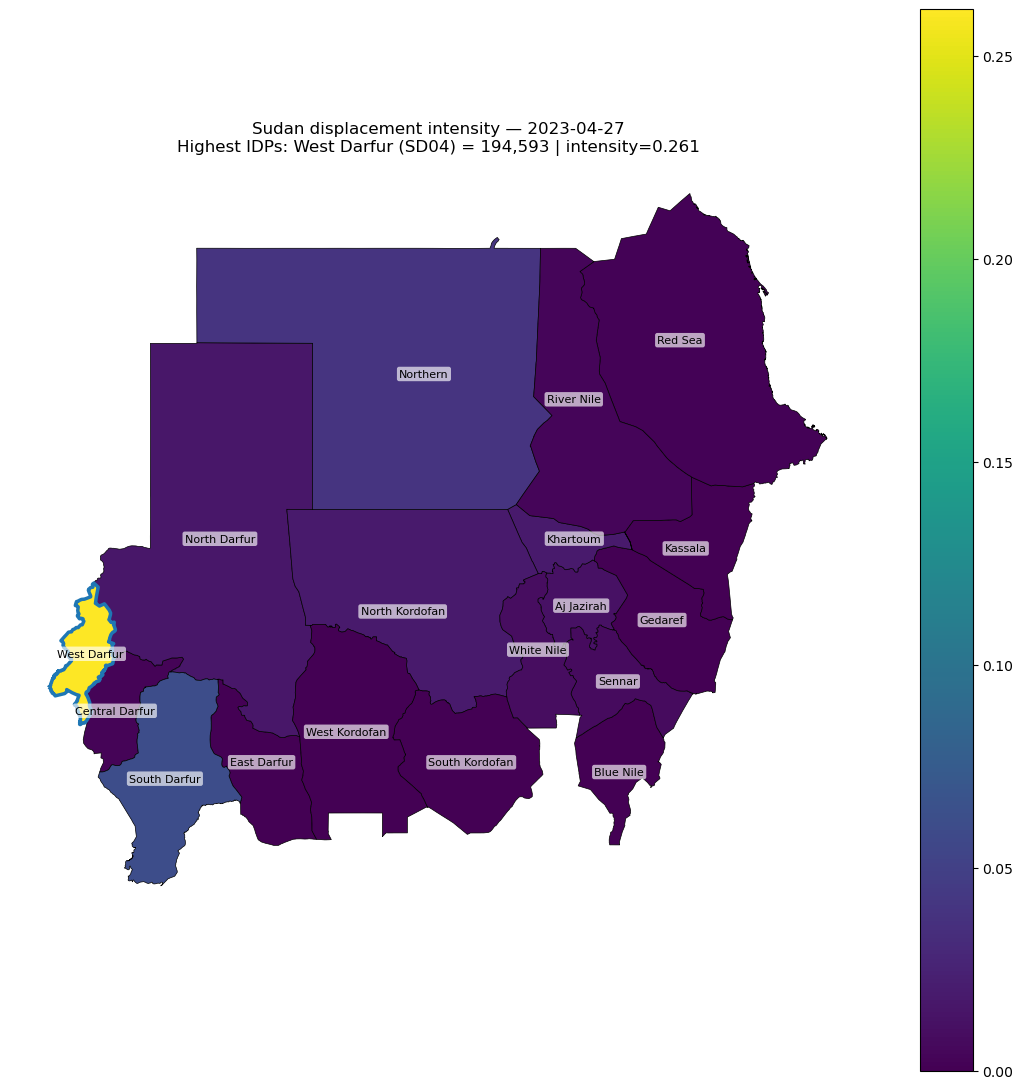


Date: 2023-04-27 | Saved: maps_out\map_admin1_intensity_2023-04-27.png
Highest displacement: West Darfur (SD04) = 194,593 | intensity=0.261464
Missing joins: 0


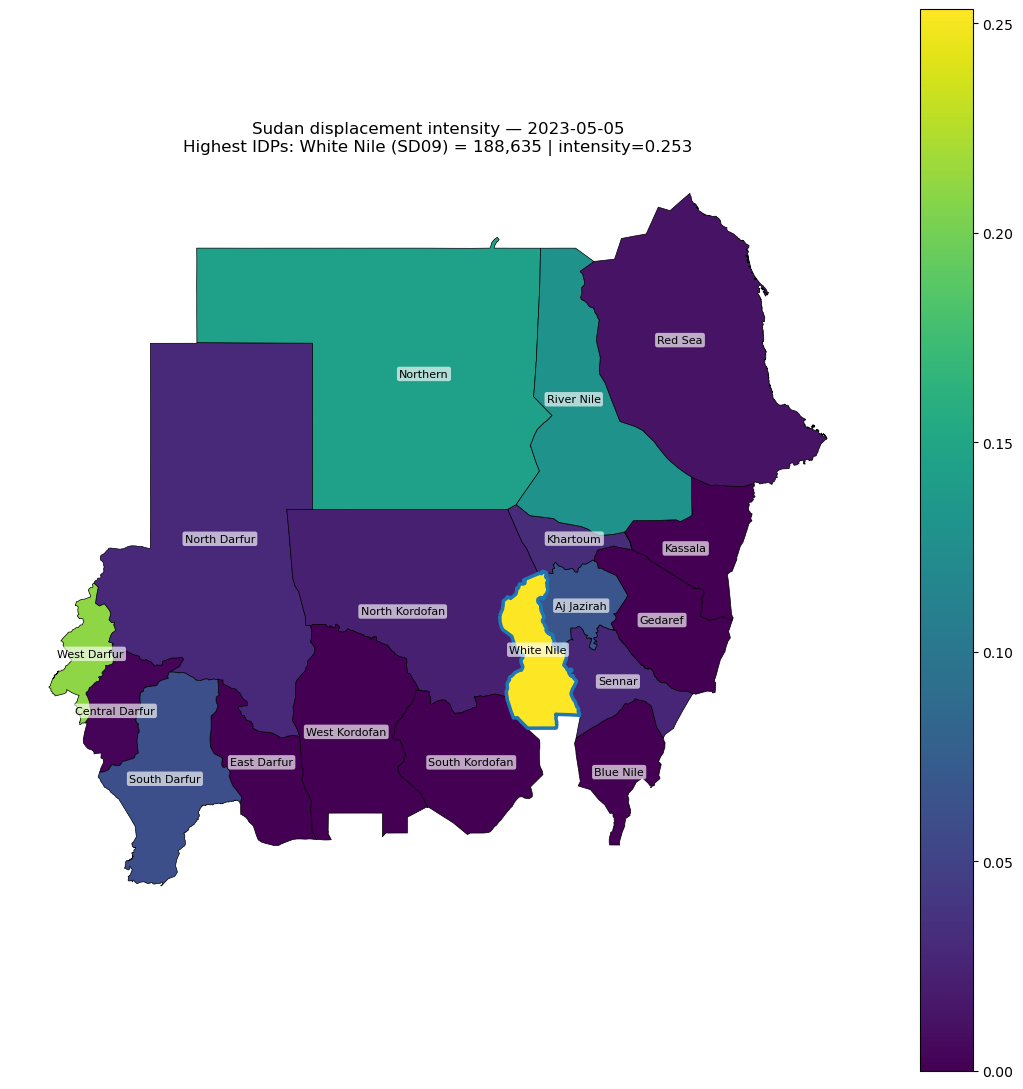


Date: 2023-05-05 | Saved: maps_out\map_admin1_intensity_2023-05-05.png
Highest displacement: White Nile (SD09) = 188,635 | intensity=0.253459
Missing joins: 0


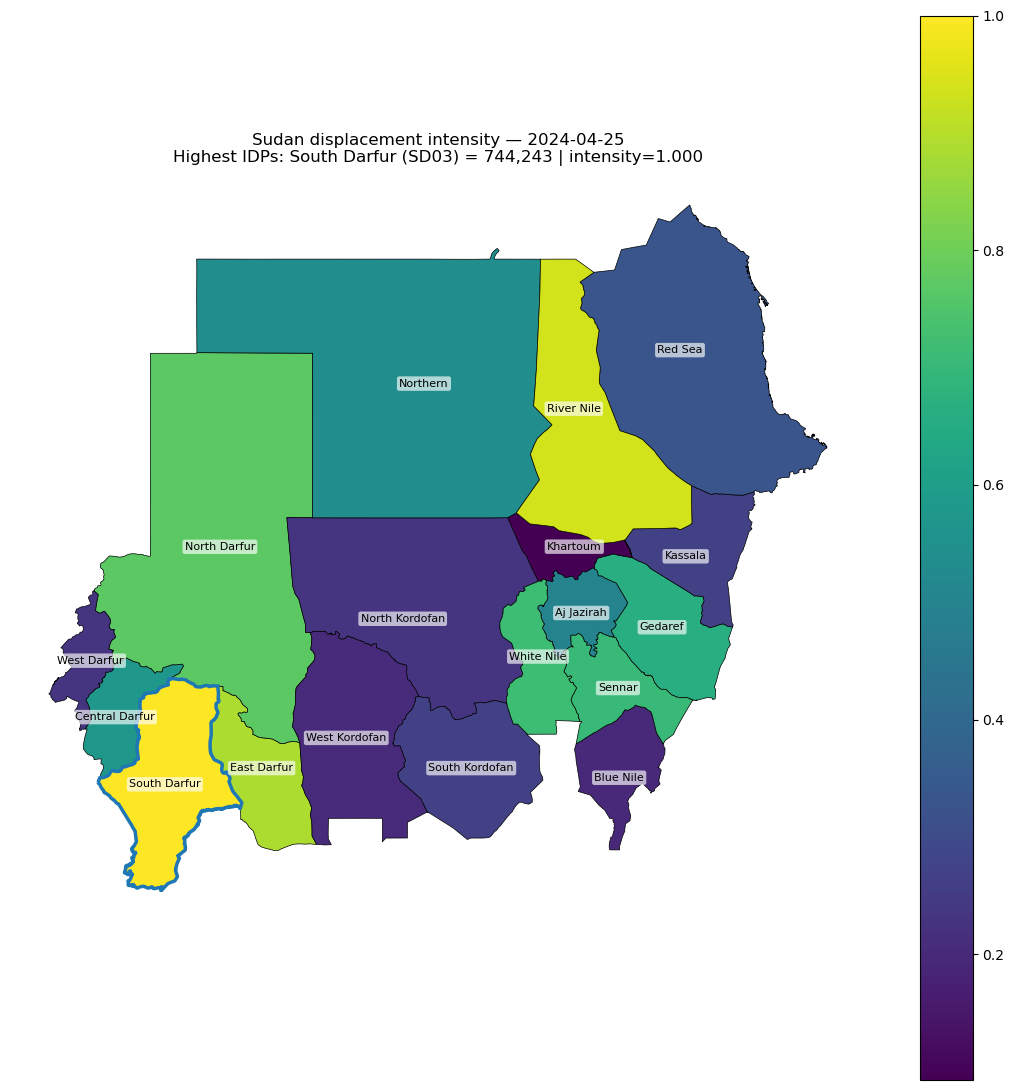


Date: 2024-04-25 | Saved: maps_out\map_admin1_intensity_2024-04-25.png
Highest displacement: South Darfur (SD03) = 744,243 | intensity=1.000000
Missing joins: 0


In [73]:
# BLOCK 2: For each snapshot -> merge -> map -> save + report

for f in snap_files:
    snap = pd.read_csv(f, parse_dates=["report_date"])
    date_str = str(snap["report_date"].iloc[0].date())

    m = gdf18.merge(snap, left_on="adm1_pcode", right_on="state_code", how="left")
    m[[idps_col, value_col]] = m[[idps_col, value_col]].fillna(0)

    missing = m[m["state_code"].isna()][["adm1_pcode", name_col]]
    max_row = m.loc[m[idps_col].idxmax()]

    ax = m.plot(column=value_col, legend=True, edgecolor="black", linewidth=0.5,
                missing_kwds={"color": "lightgrey", "label": "Missing"}, figsize=(11, 11))
    m[m["adm1_pcode"] == max_row["adm1_pcode"]].boundary.plot(ax=ax, linewidth=2.5)

    pts = m.geometry.representative_point()
    for (x, y), label in zip(zip(pts.x, pts.y), m[name_col].astype(str)):
        ax.text(x, y, label, ha="center", va="center", fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.65))

    ax.set_title(
        f"Sudan displacement intensity — {date_str}\n"
        f"Highest IDPs: {max_row[name_col]} ({max_row['adm1_pcode']}) = {float(max_row[idps_col]):,.0f} | intensity={float(max_row[value_col]):.3f}"
    )
    ax.set_axis_off()
    out_png = os.path.join("maps_out", f"map_admin1_intensity_{date_str}.png")
    plt.tight_layout(); plt.savefig(out_png, dpi=200); plt.show()

    print(f"\nDate: {date_str} | Saved: {out_png}")
    print(f"Highest displacement: {max_row[name_col]} ({max_row['adm1_pcode']}) = {float(max_row[idps_col]):,.0f} | intensity={float(max_row[value_col]):.6f}")
    print("Missing joins:", len(missing))
    if len(missing):
        print(missing.to_string(index=False))


### 1.2.2  Create Admin-1 maps that visualize only the top-5 displacement hotspots per date, using a rank-based intensity gradient while setting all other states to zero

In [74]:
# BLOCK 1: config (small)

value_col = "hotspot_intensity_rank"
name_col = next((c for c in ["adm1_en","adm1_name","adm1_name_en","name","state_name","STATE_EN"] if c in gdf18.columns), None)
if not name_col:
    raise ValueError(f"No state-name column in GeoJSON. Columns: {list(gdf18.columns)}")


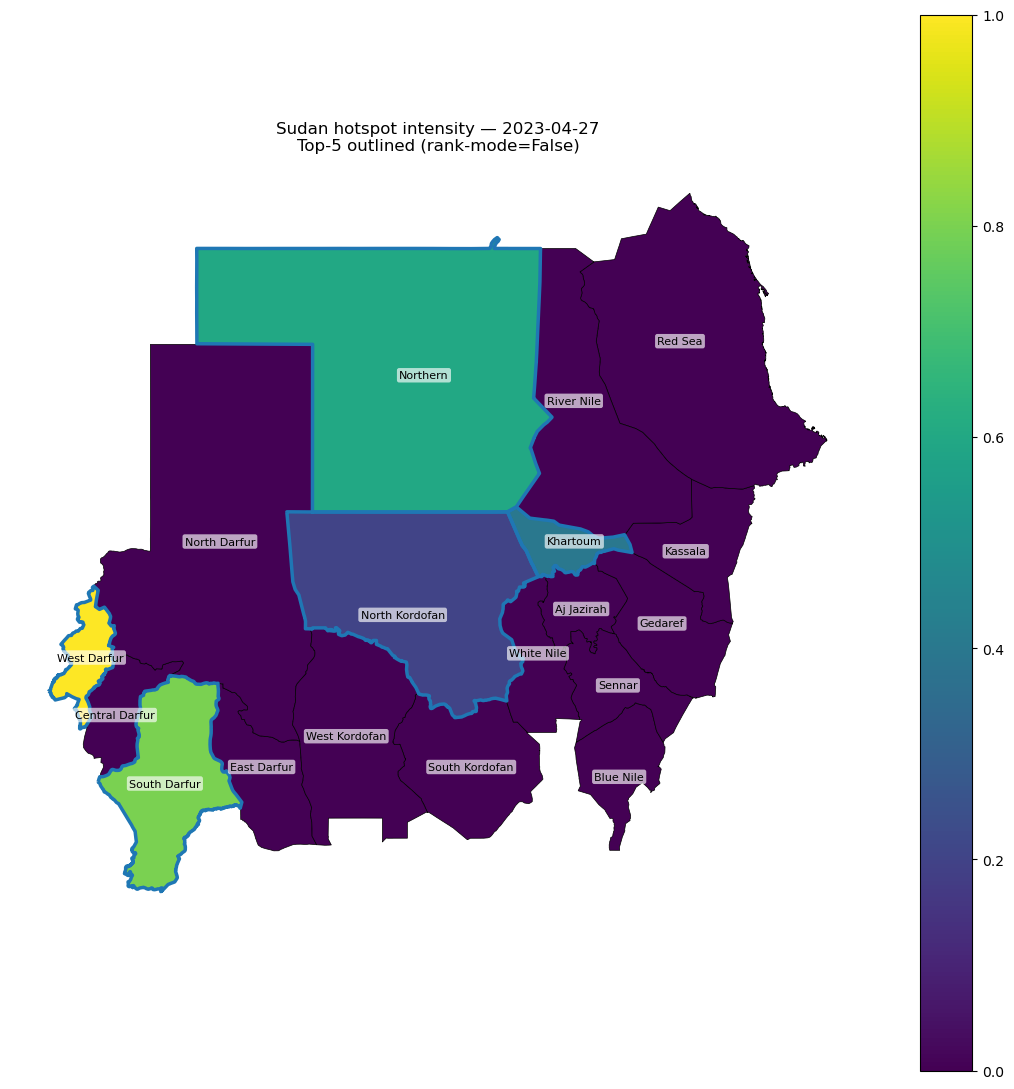


Date: 2023-04-27
1. West Darfur (SD04) = 1.0
2. South Darfur (SD03) = 0.8
3. Northern (SD17) = 0.6
4. Khartoum (SD01) = 0.4
5. North Kordofan (SD13) = 0.2
Missing joins: 0


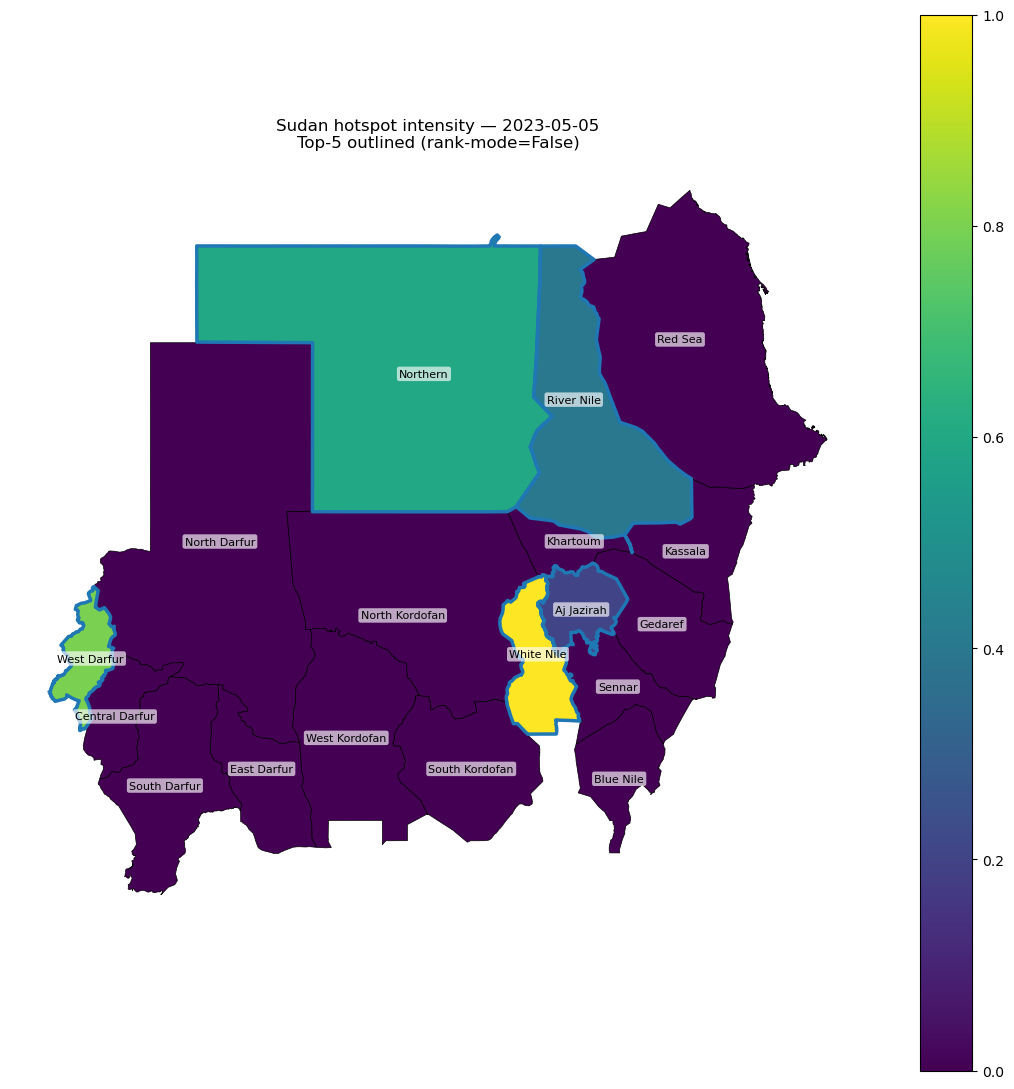


Date: 2023-05-05
1. White Nile (SD09) = 1.0
2. West Darfur (SD04) = 0.8
3. Northern (SD17) = 0.6
4. River Nile (SD16) = 0.4
5. Aj Jazirah (SD15) = 0.2
Missing joins: 0


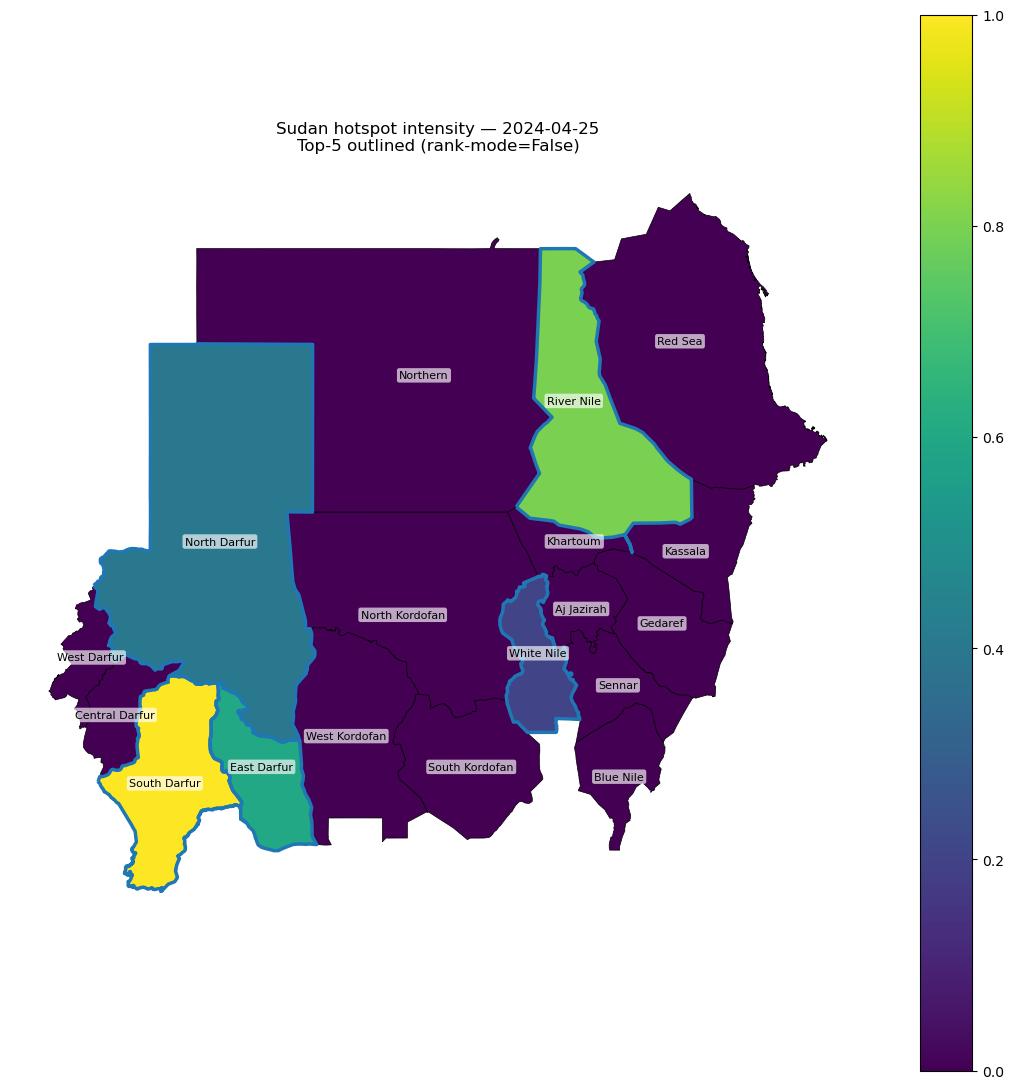


Date: 2024-04-25
1. South Darfur (SD03) = 1.0
2. River Nile (SD16) = 0.8
3. East Darfur (SD05) = 0.6
4. North Darfur (SD02) = 0.4
5. White Nile (SD09) = 0.2
Missing joins: 0


In [75]:
# BLOCK 2: loop -> decide Top5 -> map -> print (small)

for f in snap_files:
    snap = pd.read_csv(f, parse_dates=["report_date"])
    date_str = str(snap["report_date"].iloc[0].date())

    m = gdf18.merge(snap, left_on="adm1_pcode", right_on="state_code", how="left")
    m[value_col] = pd.to_numeric(m[value_col], errors="coerce").fillna(0)

    nz = m.loc[m[value_col] > 0, value_col]
    is_rank = (nz.size > 0) and nz.apply(float.is_integer).all() and set(nz.unique()).issubset({1,2,3,4,5})

    top5 = (m[m[value_col].between(1,5)].sort_values(value_col) if is_rank
            else m.sort_values(value_col, ascending=False).head(5)).copy()

    m["is_top5"] = m["adm1_pcode"].isin(top5["adm1_pcode"])

    ax = m.plot(column=value_col, legend=True, edgecolor="black", linewidth=0.5, figsize=(11, 11),
                missing_kwds={"color": "lightgrey", "label": "Missing"})
    m[m["is_top5"]].boundary.plot(ax=ax, linewidth=2.5)

    pts = m.geometry.representative_point()
    for (x, y), label in zip(zip(pts.x, pts.y), m[name_col].astype(str)):
        ax.text(x, y, label, ha="center", va="center", fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.65))

    ax.set_title(f"Sudan hotspot intensity — {date_str}\nTop-5 outlined (rank-mode={is_rank})")
    ax.set_axis_off(); plt.tight_layout(); plt.show()

    print(f"\nDate: {date_str}")
    for i, r in enumerate(top5[["adm1_pcode", name_col, value_col]].itertuples(index=False), 1):
        print(f"{i}. {getattr(r, name_col)} ({r.adm1_pcode}) = {getattr(r, value_col)}")
    print("Missing joins:", int(m["state_code"].isna().sum()))


### 1.2.3  Below code Generates and saves Admin-1 maps highlighting top-5 displacement hotspots per date, using rank-based intensity and exporting each map as a PNG image

In [76]:

os.makedirs("maps_out_hotspots", exist_ok=True)

value_col = "hotspot_intensity_rank"

for f in snap_files:
    snap = pd.read_csv(f, parse_dates=["report_date"])
    date_str = str(snap["report_date"].iloc[0].date())

    m = gdf18.merge(snap, left_on="adm1_pcode", right_on="state_code", how="left")
    m[value_col] = m[value_col].fillna(0)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    m.plot(column=value_col, legend=True, ax=ax, missing_kwds={"color": "lightgrey"})
    ax.set_title(f"Sudan hotspot intensity (Top 5) — {date_str}")
    ax.set_axis_off()
    plt.tight_layout()

    out_png = os.path.join("maps_out_hotspots", f"hotspot_top5_{date_str}.png")
    plt.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.close(fig)

    print("Saved:", out_png)


Saved: maps_out_hotspots\hotspot_top5_2023-04-27.png
Saved: maps_out_hotspots\hotspot_top5_2023-05-05.png
Saved: maps_out_hotspots\hotspot_top5_2024-04-25.png


### 1.2.4  Below Code Creates and saves Admin-1 choropleth maps using a globally scaled displacement intensity metric, ensuring consistent color comparison across different reporting dates

In [77]:
os.makedirs("maps_out_intensity_global", exist_ok=True)

value_col = "intensity_idps_global"

for f in snap_files:
    snap = pd.read_csv(f, parse_dates=["report_date"])
    date_str = str(snap["report_date"].iloc[0].date())

    m = gdf18.merge(snap, left_on="adm1_pcode", right_on="state_code", how="left")
    m[value_col] = m[value_col].fillna(0)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    m.plot(column=value_col, legend=True, ax=ax, missing_kwds={"color": "lightgrey"})
    ax.set_title(f"Sudan displacement intensity (global scaled) — {date_str}")
    ax.set_axis_off()
    plt.tight_layout()

    out_png = os.path.join("maps_out_intensity_global", f"intensity_global_{date_str}.png")
    plt.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.close(fig)

    print("Saved:", out_png)


Saved: maps_out_intensity_global\intensity_global_2023-04-27.png
Saved: maps_out_intensity_global\intensity_global_2023-05-05.png
Saved: maps_out_intensity_global\intensity_global_2024-04-25.png


### 1.2.5  This code Generates and saves Admin-1 maps showing raw IDP counts per state for each selected date, providing an unnormalized view of displacement levels.

In [78]:
os.makedirs("maps_out_idps_raw", exist_ok=True)

value_col = "idps"

for f in snap_files:
    snap = pd.read_csv(f, parse_dates=["report_date"])
    date_str = str(snap["report_date"].iloc[0].date())

    m = gdf18.merge(snap, left_on="adm1_pcode", right_on="state_code", how="left")
    m[value_col] = m[value_col].fillna(0)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    m.plot(column=value_col, legend=True, ax=ax, missing_kwds={"color": "lightgrey"})
    ax.set_title(f"Sudan IDPs (raw) — {date_str}")
    ax.set_axis_off()
    plt.tight_layout()

    out_png = os.path.join("maps_out_idps_raw", f"idps_raw_{date_str}.png")
    plt.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.close(fig)

    print("Saved:", out_png)

Saved: maps_out_idps_raw\idps_raw_2023-04-27.png
Saved: maps_out_idps_raw\idps_raw_2023-05-05.png
Saved: maps_out_idps_raw\idps_raw_2024-04-25.png


load administrative-level food security snapshots, cleans and standardizes columns (numeric conversions, boolean hotspot flags), filters for valid admin1 codes, adds helper fields for Tableau, and saves the cleaned dataset for visualization.

In [79]:
INFILE = "geo_admin1_snapshots_2023_2024_INTENSITY.csv"
OUTDIR = "tableau_outputs"
os.makedirs(OUTDIR, exist_ok=True)

df = pd.read_csv(INFILE, parse_dates=["report_date"])

# keep clean admin1 codes (SD01 to SD18)
df["state_code"] = df["state_code"].astype(str).str.strip()
df = df[df["state_code"].str.match(r"^SD\d{2}$", na=False)].copy()

# standardize types
for c in ["idps","households","rank","hotspot_intensity_rank","intensity_idps_minmax","intensity_idps_share","intensity_idps_global"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# ensure hotspot is boolean-ish
if "hotspot" in df.columns:
    df["hotspot"] = df["hotspot"].astype(bool)

# add helper fields for Tableau
df["report_date_str"] = df["report_date"].dt.strftime("%Y-%m-%d")
df["year"] = df["report_date"].dt.year

# save master
out_master = os.path.join(OUTDIR, "tableau_admin1_fact_long.csv")
df.to_csv(out_master, index=False)

print("Saved:", out_master)
print("Rows:", len(df), "| Dates:", df["report_date"].nunique(), "| States:", df["state_code"].nunique())
print("Columns:", df.columns.tolist())


Saved: tableau_outputs\tableau_admin1_fact_long.csv
Rows: 54 | Dates: 3 | States: 18
Columns: ['state_code', 'state_name', 'report_date', 'idps', 'households', 'rank', 'hotspot', 'year', 'hotspot_intensity_rank', 'intensity_idps_minmax', 'intensity_idps_share', 'intensity_idps_global', 'report_date_str']


State by IDPs for each reporting date, creating a subset of high-intensity hotspots, and saves it as a CSV for Tableau visualization.

In [80]:
OUTDIR = "tableau_outputs"
df = pd.read_csv(os.path.join(OUTDIR, "tableau_admin1_fact_long.csv"), parse_dates=["report_date"])

top5 = (df.sort_values(["report_date","idps"], ascending=[True, False])
          .groupby("report_date")
          .head(5)
          .copy())

out_top5 = os.path.join(OUTDIR, "tableau_hotspots_top5.csv")
top5.to_csv(out_top5, index=False)

print("Saved:", out_top5)
print(top5[["report_date_str","state_code","state_name","idps","rank","hotspot_intensity_rank"]].to_string(index=False))


Saved: tableau_outputs\tableau_hotspots_top5.csv
report_date_str state_code     state_name     idps  rank  hotspot_intensity_rank
     2023-04-27       SD04    West Darfur 194593.0   1.0                     1.0
     2023-04-27       SD03   South Darfur  45000.0   2.0                     0.8
     2023-04-27       SD17       Northern  29200.0   3.0                     0.6
     2023-04-27       SD01       Khartoum  13545.0   4.0                     0.4
     2023-04-27       SD13 North Kordofan  13270.0   5.0                     0.2
     2023-05-05       SD09     White Nile 188635.0   1.0                     1.0
     2023-05-05       SD04    West Darfur 156565.0   2.0                     0.8
     2023-05-05       SD17       Northern 106600.0   3.0                     0.6
     2023-05-05       SD16     River Nile  96095.0   4.0                     0.4
     2023-05-05       SD15     Aj Jazirah  49280.0   5.0                     0.2
     2024-04-25       SD03   South Darfur 744243.0   1.0    

Pivot the admin1-level data to create a wide table of rank values for each state across reporting dates, making it easier to visualize trends in Tableau, and saves the result as a CSV.

In [81]:
OUTDIR = "tableau_outputs"
df = pd.read_csv(os.path.join(OUTDIR, "tableau_admin1_fact_long.csv"), parse_dates=["report_date"])

rank_wide = (df.pivot_table(index=["state_code","state_name"],
                            columns="report_date_str",
                            values="rank",
                            aggfunc="min")
               .reset_index())

# make columns simpler for use in Tableau 
rank_wide.columns.name = None

out_rank = os.path.join(OUTDIR, "tableau_rank_wide.csv")
rank_wide.to_csv(out_rank, index=False)

print("Saved:", out_rank)
print(rank_wide.head(10).to_string(index=False))


Saved: tableau_outputs\tableau_rank_wide.csv
state_code     state_name  2023-04-27  2023-05-05  2024-04-25
      SD01       Khartoum         4.0         7.0        18.0
      SD02   North Darfur         6.0         8.0         4.0
      SD03   South Darfur         2.0         6.0         1.0
      SD04    West Darfur         1.0         2.0        14.0
      SD05    East Darfur        16.0        16.0         3.0
      SD06 Central Darfur        11.0        12.0         8.0
      SD07 South Kordofan        15.0        17.0        13.0
      SD08      Blue Nile        13.0        13.0        17.0
      SD09     White Nile         8.0         1.0         5.0
      SD10        Red Sea        12.0        11.0        11.0


Calculate the change in IDPs and rank for each state between the first and last reporting dates, generating a summary table of trends for Tableau visualization and saving it as a CSV.

In [82]:
OUTDIR = "tableau_outputs"
df = pd.read_csv(os.path.join(OUTDIR, "tableau_admin1_fact_long.csv"), parse_dates=["report_date"])

first_d = df["report_date"].min()
last_d = df["report_date"].max()

a = df[df["report_date"] == first_d][["state_code","state_name","idps","rank"]].rename(
    columns={"idps":"idps_first","rank":"rank_first"}
)
b = df[df["report_date"] == last_d][["state_code","idps","rank"]].rename(
    columns={"idps":"idps_last","rank":"rank_last"}
)

chg = a.merge(b, on="state_code", how="left")
chg["idps_last"] = chg["idps_last"].fillna(0)
chg["rank_last"] = chg["rank_last"].fillna(0)

chg["delta_idps"] = chg["idps_last"] - chg["idps_first"]
chg["delta_rank"] = chg["rank_last"] - chg["rank_first"]

chg["first_date"] = first_d.strftime("%Y-%m-%d")
chg["last_date"] = last_d.strftime("%Y-%m-%d")

out_chg = os.path.join(OUTDIR, "tableau_change_first_vs_last.csv")
chg.to_csv(out_chg, index=False)

print("Saved:", out_chg)
print("Comparing:", first_d.date(), "->", last_d.date())
print(chg.sort_values("delta_idps", ascending=False).head(10).to_string(index=False))


Saved: tableau_outputs\tableau_change_first_vs_last.csv
Comparing: 2023-04-27 -> 2024-04-25
state_code     state_name  idps_first  rank_first  idps_last  rank_last  delta_idps  delta_rank first_date  last_date
      SD03   South Darfur     45000.0         2.0   744243.0        1.0    699243.0        -1.0 2023-04-27 2024-04-25
      SD16     River Nile      2910.0        10.0   698334.0        2.0    695424.0        -8.0 2023-04-27 2024-04-25
      SD05    East Darfur         0.0        16.0   660140.0        3.0    660140.0       -13.0 2023-04-27 2024-04-25
      SD02   North Darfur     11675.0         6.0   573055.0        4.0    561380.0        -2.0 2023-04-27 2024-04-25
      SD09     White Nile      6165.0         8.0   532643.0        5.0    526478.0        -3.0 2023-04-27 2024-04-25
      SD14         Sennar      5560.0         9.0   523986.0        6.0    518426.0        -3.0 2023-04-27 2024-04-25
      SD12        Gedaref         0.0        17.0   492293.0        7.0    492293.

Compress all files in the tableau_outputs directory into a single ZIP archive (tableau_outputs_deploy.zip) for easy sharing or deployment.

In [83]:
OUTDIR = "tableau_outputs"
ZIPNAME = "tableau_outputs_deploy.zip"

with zipfile.ZipFile(ZIPNAME, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for fn in os.listdir(OUTDIR):
        z.write(os.path.join(OUTDIR, fn), arcname=f"{OUTDIR}/{fn}")

print("Saved:", ZIPNAME)
print("Files zipped:", os.listdir(OUTDIR))


Saved: tableau_outputs_deploy.zip
Files zipped: ['tableau_admin1_fact_long.csv', 'tableau_change_first_vs_last.csv', 'tableau_hotspots_top5.csv', 'tableau_rank_wide.csv']


## 10. Deployment 

**Final Models Ready for Deployment**:
- Regression: Tuned Random Forest (R²=0.4285)
- Classification: Random Forest (Accuracy=65.3%, F1=0.541)

### Deployment And Protype Demo

This has been handled seperately. We used StreamLit methodology for deployment. 
The deployment code was captured seperately and will be showcased together with our final prototype demo.


In [90]:

!conda activate learn-env


In [91]:
import sys
print("Python executable:", sys.executable)


Python executable: C:\Users\user\anaconda3\envs\learn-env\python.exe


In [92]:
from pathlib import Path
import numpy as np
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import ipywidgets as widgets

ROOT = Path(".")

FOOD_MASTER = ROOT / "regional_food_security_master.csv"
DISP_FACT   = ROOT / "geo_admin1_snapshots_2023_2024_INTENSITY.csv"
HOTSPOTS    = ROOT / "report_hotspots_top5_by_date.csv"  # optional
ADMIN1_GEOJSON = ROOT / "sdn_admin_boundaries_unzipped" / "sdn_admin1.geojson"


In [93]:
def safe_read_csv(p: Path, **kwargs):
    if not p.exists():
        print(f"[Missing file] {p}")
        return None
    try:
        return pd.read_csv(p, **kwargs)
    except Exception as e:
        print(f"Could not read {p}: {e}")
        return None


def df_search_filter(df: pd.DataFrame, q: str) -> pd.DataFrame:
    if df is None or df.empty or not q:
        return df
    q = q.lower().strip()
    try:
        mask = df.astype(str).apply(lambda row: row.str.lower().str.contains(q, na=False)).any(axis=1)
        return df[mask]
    except Exception:
        return df


In [94]:
def load_food_master(p: Path):
    df = safe_read_csv(p, low_memory=False)
    if df is None:
        return None

    if "From" in df.columns:
        df = df[~df["From"].astype(str).str.startswith("#")].copy()
        df["From"] = pd.to_datetime(df["From"], errors="coerce")
        df = df.dropna(subset=["From"]).copy()
        df["month"] = df["From"].dt.to_period("M").dt.to_timestamp()

    for c in ["Country", "Phase"]:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()

    if "Area" in df.columns or "state" in df.columns:
        area = df["Area"] if "Area" in df.columns else pd.Series([None] * len(df))
        state = df["state"] if "state" in df.columns else pd.Series([None] * len(df))
        df["admin"] = area.where(area.notna(), state).astype(str).str.strip()

    if "Percentage" in df.columns:
        df["Percentage"] = pd.to_numeric(df["Percentage"], errors="coerce")

    return df


def build_food_panel(df):
    req = {"Country", "admin", "month", "Phase", "Percentage"}
    if df is None or not req.issubset(df.columns):
        return None

    clean = df.dropna(subset=["Country", "admin", "month", "Phase", "Percentage"]).copy()

    panel = (
        clean.pivot_table(
            index=["Country", "admin", "month"],
            columns="Phase",
            values="Percentage",
            aggfunc="first",
        )
        .reset_index()
    )

    panel.columns = [
        ("phase_" + str(c).replace("+", "plus").replace(" ", "").lower())
        if c not in ["Country", "admin", "month"]
        else c
        for c in panel.columns
    ]

    panel = panel.sort_values(["Country", "admin", "month"]).copy()

    panel["month_num"] = panel["month"].dt.month
    panel["sin_month"] = np.sin(2 * np.pi * panel["month_num"] / 12)
    panel["cos_month"] = np.cos(2 * np.pi * panel["month_num"] / 12)

    if "phase_3plus" in panel.columns:
        panel["ipc3plus_lag1"] = panel.groupby(["Country", "admin"])["phase_3plus"].shift(1)
        panel["ipc3plus_lag2"] = panel.groupby(["Country", "admin"])["phase_3plus"].shift(2)
        panel["ipc3plus_lag3"] = panel.groupby(["Country", "admin"])["phase_3plus"].shift(3)

        panel["ipc3plus_roll3"] = (
            panel.groupby(["Country", "admin"])["phase_3plus"]
            .apply(lambda s: s.shift(1).rolling(3).mean())
            .reset_index(level=[0, 1], drop=True)
        )

        panel["ipc3plus_next"] = panel.groupby(["Country", "admin"])["phase_3plus"].shift(-1)
        panel["ipc3plus_delta_next"] = panel["ipc3plus_next"] - panel["phase_3plus"]
        panel["worsen_next_2pp"] = (panel["ipc3plus_delta_next"] >= 0.02).astype(int)

    return panel


In [95]:
def load_displacement_fact(p: Path):
    df = safe_read_csv(p, low_memory=False)
    if df is None:
        return None

    for dcol in ["report_date", "date", "Date"]:
        if dcol in df.columns:
            df[dcol] = pd.to_datetime(df[dcol], errors="coerce")
            if dcol != "report_date":
                df["report_date"] = df[dcol]
            break

    num_cols = [
        "idps",
        "households",
        "rank",
        "hotspot_intensity_rank",
        "intensity_idps_minmax",
        "intensity_idps_share",
        "intensity_idps_global",
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    return df


def load_admin1(geojson_path: Path):
    if not geojson_path.exists():
        return None, None
    gdf = gpd.read_file(str(geojson_path))
    gdf["adm1_pcode"] = gdf["adm1_pcode"].astype(str).str.strip()

    keep_codes = [f"SD{str(i).zfill(2)}" for i in range(1, 19)]
    gdf = gdf[gdf["adm1_pcode"].isin(keep_codes)].copy()

    name_candidates = ["adm1_en", "adm1_name", "adm1_name_en", "name", "state_name", "STATE_EN"]
    name_col = next((c for c in name_candidates if c in gdf.columns), None)
    if name_col is None:
        raise ValueError(f"No state name column found. Columns: {list(gdf.columns)}")

    return gdf, name_col


def plot_admin1_map(gdf, name_col, snap_df, value_col, title):
    m = gdf.merge(snap_df, left_on="adm1_pcode", right_on="state_code", how="left")
    m[value_col] = pd.to_numeric(m[value_col], errors="coerce").fillna(0)

    label_points = m.geometry.representative_point()

    fig, ax = plt.subplots(1, 1, figsize=(11, 11))
    m.plot(
        column=value_col,
        legend=True,
        ax=ax,
        missing_kwds={"color": "lightgrey"},
        edgecolor="black",
        linewidth=0.5,
    )

    for (x, y), label in zip(zip(label_points.x, label_points.y), m[name_col].astype(str)):
        ax.text(
            x, y, label,
            ha="center", va="center", fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
        )

    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    return fig, m


In [96]:
df_food_raw = load_food_master(FOOD_MASTER)
panel = build_food_panel(df_food_raw) if df_food_raw is not None else None

df_disp = load_displacement_fact(DISP_FACT)
gdf_admin, name_col = load_admin1(ADMIN1_GEOJSON)

print("Food panel:", None if panel is None else panel.shape)
print("Displacement:", None if df_disp is None else df_disp.shape)
print("Admin gdf:", None if gdf_admin is None else gdf_admin.shape, "name_col:", name_col)


Food panel: (3695, 20)
Displacement: (54, 12)
Admin gdf: (18, 22) name_col: adm1_name


In [97]:
def food_view(country, admin, month, search_text, show_table=True):
    clear_output(wait=True)
    if panel is None:
        print("Missing/invalid food panel.")
        return

    month_dt = pd.to_datetime(month)

    snap_raw = panel[
        (panel["Country"] == country) &
        (panel["admin"] == admin) &
        (panel["month"] == month_dt)
    ].copy()

    print("Food Security Report (IPC Phase 3+)")
    print(f"Country: {country} | Admin: {admin} | Month: {month_dt.date()}")
    print("-"*70)

    if snap_raw.empty:
        print("No data for that Country/Admin/Month selection.")
        return

    row = snap_raw.iloc[0]
    if ("ipc3plus_next" in snap_raw.columns) and pd.notna(row.get("ipc3plus_next", np.nan)):
        current = float(row["phase_3plus"])
        nextm = float(row["ipc3plus_next"])
        delta = nextm - current
        worsened = int(delta >= 0.02)

        print(f"Current IPC3+ share: {current:.3f}")
        print(f"Next-month IPC3+ (observed): {nextm:.3f}")
        print(f"Change (next - current): {delta:.3f}")
        print(f"Outcome: {'WORSENED (≥ +2pp)' if worsened == 1 else 'DID NOT WORSEN'}")
    else:
        print("Observed next-month outcome not available (latest month or missing next month).")

    snap = df_search_filter(snap_raw, search_text)

    if show_table:
        display(snap)


In [98]:
countries = sorted(panel["Country"].dropna().unique())
country_w = widgets.Dropdown(options=countries, description="Country:", layout=widgets.Layout(width="360px"))

def admins_for_country(c):
    return sorted(panel.loc[panel["Country"] == c, "admin"].dropna().unique())

admin_w = widgets.Dropdown(options=admins_for_country(countries[0]), description="Admin:", layout=widgets.Layout(width="360px"))

def months_for_selection(c, a):
    months = panel.loc[(panel["Country"] == c) & (panel["admin"] == a), "month"].dropna().unique()
    months = sorted(pd.to_datetime(months))
    return [str(m.date()) for m in months]

month_w = widgets.Dropdown(options=months_for_selection(countries[0], admin_w.value), description="Month:", layout=widgets.Layout(width="220px"))

search_w = widgets.Text(value="", description="Search:", layout=widgets.Layout(width="520px"))
show_table_w = widgets.Checkbox(value=True, description="Show table")

def on_country_change(change):
    admin_w.options = admins_for_country(change["new"])
    admin_w.value = admin_w.options[0]
    month_w.options = months_for_selection(country_w.value, admin_w.value)
    month_w.value = month_w.options[0]

def on_admin_change(change):
    month_w.options = months_for_selection(country_w.value, change["new"])
    month_w.value = month_w.options[0]

country_w.observe(on_country_change, names="value")
admin_w.observe(on_admin_change, names="value")

ui_food = widgets.VBox([
    widgets.HTML("<h3>Food Report (IPC Phase 3+)</h3>"),
    widgets.HBox([country_w, admin_w, month_w]),
    widgets.HBox([search_w, show_table_w])
])

out_food = widgets.interactive_output(
    food_view,
    {"country": country_w, "admin": admin_w, "month": month_w, "search_text": search_w, "show_table": show_table_w}
)

display(ui_food, out_food)


Output()

In [99]:
def disp_view(year, search_text, show_table=True, max_rows=500):
    clear_output(wait=True)
    if df_disp is None or df_disp.empty:
        print("Missing displacement dataset.")
        return

    if "report_date" not in df_disp.columns or df_disp["report_date"].isna().all():
        print("No valid report_date values found.")
        return

    d = df_disp.copy()
    d["year"] = d["report_date"].dt.year

    view = d[d["year"] == year].copy()
    view = df_search_filter(view, search_text)

    print(f"Displacement Report (Admin-1 Intensity) — Year: {year}")
    print("-"*70)

    if show_table:
        display(view.head(max_rows))

    if HOTSPOTS.exists():
        df_hot = safe_read_csv(HOTSPOTS, low_memory=False)
        if df_hot is not None:
            for dcol in ["report_date", "date", "Date"]:
                if dcol in df_hot.columns:
                    df_hot[dcol] = pd.to_datetime(df_hot[dcol], errors="coerce")
                    if dcol != "report_date":
                        df_hot["report_date"] = df_hot[dcol]
                    break

            if "report_date" in df_hot.columns:
                df_hot["year"] = df_hot["report_date"].dt.year
                df_hot_view = df_hot[df_hot["year"] == year].copy()
            else:
                df_hot_view = df_hot.copy()

            print("\nTop-5 hotspots by date")
            display(df_search_filter(df_hot_view, search_text).head(max_rows))


In [100]:
years = sorted(df_disp["report_date"].dropna().dt.year.unique())
year_w = widgets.Dropdown(options=years, value=years[-1], description="Year:", layout=widgets.Layout(width="220px"))
search2_w = widgets.Text(value="", description="Search:", layout=widgets.Layout(width="520px"))
show2_w = widgets.Checkbox(value=True, description="Show tables")

ui_disp = widgets.VBox([
    widgets.HTML("<h3>Displacement (Tables)</h3>"),
    widgets.HBox([year_w, search2_w, show2_w])
])

out_disp = widgets.interactive_output(
    disp_view,
    {"year": year_w, "search_text": search2_w, "show_table": show2_w}
)

display(ui_disp, out_disp)


Output()

In [101]:
def maps_view(sel_date):
    clear_output(wait=True)
    if gdf_admin is None or df_disp is None:
        print("Missing admin boundaries or displacement data.")
        return

    sel_dt = pd.to_datetime(sel_date)
    snap = df_disp[df_disp["report_date"] == sel_dt].copy()
    if snap.empty:
        print("No snapshot found for selected date.")
        return

    print(f"Maps (LIVE + State Names) — {sel_dt.date()}")
    print("-"*70)

    fig1, m1 = plot_admin1_map(
        gdf_admin, name_col, snap,
        value_col="intensity_idps_global",
        title=f"Sudan displacement intensity (global) — {sel_dt.date()}",
    )
    plt.show()

    if "idps" in m1.columns and m1["idps"].notna().any():
        idx = m1["idps"].idxmax()
        print(f"Highest IDPs: {m1.loc[idx, name_col]} ({m1.loc[idx,'adm1_pcode']}) = {m1.loc[idx,'idps']:,.0f}")

    print("\n" + "-"*70 + "\n")

    fig2, m2 = plot_admin1_map(
        gdf_admin, name_col, snap,
        value_col="hotspot_intensity_rank",
        title=f"Sudan hotspots (rank 1–5) — {sel_dt.date()}",
    )
    plt.show()

    if "hotspot_intensity_rank" in m2.columns:
        top5 = m2[m2["hotspot_intensity_rank"].between(1, 5)].copy()
        if len(top5) > 0:
            top5 = top5.sort_values("hotspot_intensity_rank")[[name_col, "adm1_pcode", "hotspot_intensity_rank"]]
            print("Top 5 hotspots (rank 1 = highest):")
            display(top5)
        else:
            print("No hotspot ranks 1..5 found for this date.")


In [102]:
dates = sorted(pd.to_datetime(df_disp["report_date"].dropna().unique()))
date_opts = [str(d.date()) for d in dates]

date_w = widgets.Dropdown(options=date_opts, value=date_opts[-1], description="Report date:", layout=widgets.Layout(width="260px"))

ui_maps = widgets.VBox([
    widgets.HTML("<h3>Maps (LIVE + State Names)</h3>"),
    date_w
])

out_maps = widgets.interactive_output(maps_view, {"sel_date": date_w})
display(ui_maps, out_maps)


Output()

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier

model_frame = panel.dropna(subset=["phase_3plus"]).copy()
model_frame["ipc3plus_next"] = model_frame.groupby(["Country","admin"])["phase_3plus"].shift(-1)
model_frame["ipc3plus_delta_next"] = model_frame["ipc3plus_next"] - model_frame["phase_3plus"]
model_frame["worsen_next_2pp"] = (model_frame["ipc3plus_delta_next"] >= 0.02).astype(int)

model_df = model_frame.dropna(subset=["ipc3plus_next"]).copy()

feat_cols = ["phase_3plus", "ipc3plus_lag1", "ipc3plus_lag2", "ipc3plus_lag3", "ipc3plus_roll3", "sin_month", "cos_month"]

X = model_df[feat_cols]
y_reg = model_df["ipc3plus_next"]
y_clf = model_df["worsen_next_2pp"]

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), feat_cols)
])

reg_model = Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))])
clf_model = Pipeline([("prep", preprocess), ("model", RandomForestClassifier(n_estimators=300, random_state=42))])

reg_model.fit(X, y_reg)
clf_model.fit(X, y_clf)

print("Models trained.")


Models trained.


In [104]:
def month_features(dt: pd.Timestamp):
    m = int(dt.month)
    return np.sin(2*np.pi*m/12), np.cos(2*np.pi*m/12)

def forecast_2026(panel_df: pd.DataFrame, reg_pipe, clf_pipe, year=2026):
    hist = panel_df.sort_values(["Country","admin","month"]).copy()

    needed = ["ipc3plus_lag1","ipc3plus_lag2","ipc3plus_lag3","ipc3plus_roll3"]
    for col in needed:
        if col not in hist.columns:
            raise ValueError(f"Missing {col}. Run build_food_panel first.")

    series_map = {}
    for (c,a), g in hist.groupby(["Country","admin"]):
        g2 = g.dropna(subset=["phase_3plus"]).sort_values("month")
        series_map[(c,a)] = list(zip(pd.to_datetime(g2["month"]).tolist(), g2["phase_3plus"].tolist()))

    preds = []

    for month in range(1, 13):
        target_month = pd.Timestamp(year=year, month=month, day=1)

        for (c,a), series in series_map.items():
            series = [(d,v) for d,v in series if d < target_month]
            if len(series) == 0:
                continue

            current_dt, current_val = series[-1]

            lag1 = series[-1][1] if len(series) >= 1 else np.nan
            lag2 = series[-2][1] if len(series) >= 2 else np.nan
            lag3 = series[-3][1] if len(series) >= 3 else np.nan

            if len(series) >= 3:
                roll3 = np.mean([series[-1][1], series[-2][1], series[-3][1]])
            else:
                roll3 = np.nan

            sin_m, cos_m = month_features(target_month)

            X_one = pd.DataFrame([{
                "phase_3plus": float(current_val),
                "ipc3plus_lag1": float(lag1) if pd.notna(lag1) else np.nan,
                "ipc3plus_lag2": float(lag2) if pd.notna(lag2) else np.nan,
                "ipc3plus_lag3": float(lag3) if pd.notna(lag3) else np.nan,
                "ipc3plus_roll3": float(roll3) if pd.notna(roll3) else np.nan,
                "sin_month": sin_m,
                "cos_month": cos_m
            }])

            pred_next = float(reg_pipe.predict(X_one)[0])
            pred_next = max(0.0, min(1.0, pred_next))  # clamp share to [0,1]

            prob_worsen = float(clf_pipe.predict_proba(X_one)[:,1][0])

            preds.append({
                "Country": c,
                "admin": a,
                "month": target_month,
                "ipc3plus_pred": pred_next,
                "prob_worsen_2pp": prob_worsen
            })

            # recursive update
            series_map[(c,a)] = series + [(target_month, pred_next)]

    return pd.DataFrame(preds).sort_values(["Country","admin","month"]).reset_index(drop=True)

pred_2026 = forecast_2026(panel, reg_model, clf_model, year=2026)
pred_2026.head()


,Country,admin,month,ipc3plus_pred,prob_worsen_2pp
0,SDN,Abassiya,2026-01-01,0.499669,0.958889
1,SDN,Abassiya,2026-02-01,0.579751,0.976667
2,SDN,Abassiya,2026-03-01,0.559907,0.363333
3,SDN,Abassiya,2026-04-01,0.522349,0.340000
4,SDN,Abassiya,2026-05-01,0.511392,0.416667


In [105]:
out_path = ROOT / "ipc3plus_predictions_2026.csv"
pred_2026.to_csv(out_path, index=False)
print("Saved:", out_path.resolve())


Saved: C:\Users\user\Documents\Humanitarian_BACKUP\ipc3plus_predictions_2026.csv


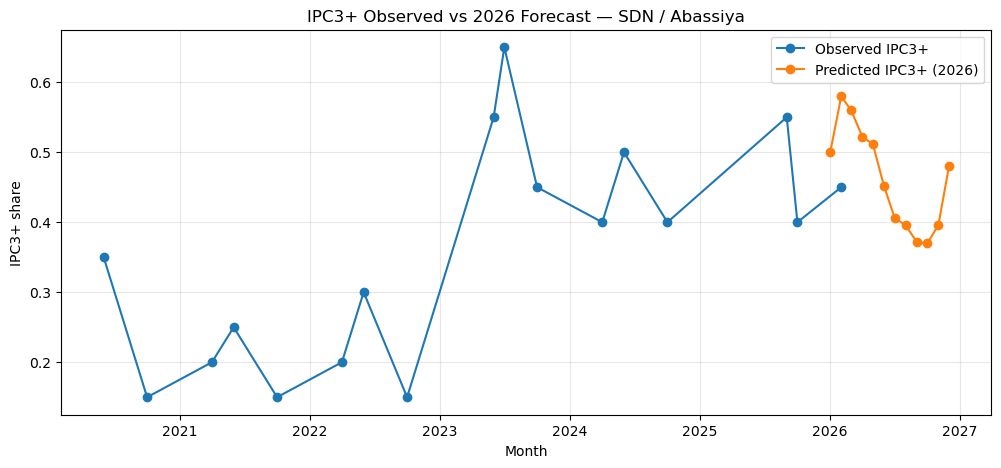

In [106]:
def plot_series(country, admin):
    obs = panel[(panel["Country"]==country) & (panel["admin"]==admin)][["month","phase_3plus"]].dropna().copy()
    fut = pred_2026[(pred_2026["Country"]==country) & (pred_2026["admin"]==admin)][["month","ipc3plus_pred"]].copy()

    plt.figure(figsize=(12,5))
    plt.plot(obs["month"], obs["phase_3plus"], marker="o", label="Observed IPC3+")
    plt.plot(fut["month"], fut["ipc3plus_pred"], marker="o", label="Predicted IPC3+ (2026)")
    plt.title(f"IPC3+ Observed vs 2026 Forecast — {country} / {admin}")
    plt.xlabel("Month")
    plt.ylabel("IPC3+ share")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_series(countries[0], admins_for_country(countries[0])[0])


In [ ]:
%cd C:\Users\user\Documents\Humanitarian_BACKUP
!streamlit cache clear
!streamlit run app.py


C:\Users\user\Documents\Humanitarian_BACKUP


## Conclusion

This project analyzed internal displacement patterns using Admin-1 level data and geospatial visualization techniques. 
By generating multiple map types—including ranked hotspot maps, globally scaled intensity maps, and raw IDP count choropleths the analysis provided a multi-perspective view of displacement dynamics over time. 

These visualizations highlighted both persistent and emerging displacement hotspots, while also enabling consistent comparison across reporting dates.

The use of different normalization approaches proved valuable in balancing interpretability and accuracy. Rank-based maps effectively emphasized relative severity within each time period, while globally scaled intensity maps supported longitudinal comparison. Raw IDP count maps further complemented the analysis by preserving absolute displacement figures. Together, these methods enhanced situational awareness and improved understanding of spatial and temporal displacement trends.

Overall, the project demonstrates how geospatial analysis can support evidence-based humanitarian decision-making by transforming complex displacement data into actionable insights.

### Recommendations

Incorporate Population Normalization Future analyses could normalize IDP counts by total population at the Admin-1 level to better capture displacement intensity relative to population size.

Extend Temporal Coverage Including additional reporting periods would allow for trend analysis, seasonal pattern detection, and improved early-warning capabilities.

Integrate Contextual Indicators Combining displacement data with conflict events, climate shocks, or food security indicators could help explain underlying drivers of displacement.

Develop Interactive Dashboards Transforming static maps into interactive dashboards (e.g., using Plotly or Dash) would improve usability for policymakers and humanitarian actors.

Automate Data Updates Implementing automated data ingestion and map generation pipelines would ensure timely updates and support rapid response planning.
